In [1]:
# import matplotlib.pyplot as plt

import numpy as np
from PYNQ_Car.CarOverlay.CarOverlay import CarOverlay
from xiaogong import PIDController
from pynq import GPIO
from PIL import Image
import IPython
import time
from pynq.xlnk import Xlnk
from pynq.lib.video.common import VideoMode
from PYNQ_Car.Infra.camera import Camera
from PYNQ_Car.Infra.MotionController import MotionController
import cv2
from pynq.lib.video.pipeline import PixelPacker
xlnk = Xlnk()
overlay = CarOverlay('/usr/local/lib/python3.6/dist-packages/PYNQ_Car/Overlay/Car.bit')

In [2]:
OV5640 = Camera(overlay.OV5640)
video_proc = overlay.video_proc
mc = MotionController(overlay.Arduino)

In [3]:
hdmi_out = overlay.video_output.axi_vdma.writechannel
out_unpack = overlay.video_output.pixel_unpack
hdmi_out.mode = VideoMode(1280,720,24)
out_unpack.bits_per_pixel = 24
overlay.OV5640.readchannel.tie(hdmi_out)
hdmi_out.start()

### 编写在notebook上显示图像的函数

In [4]:
def imshow_rgba(frame):
    image = Image.fromarray(frame)
    r, g, b = image.split()
    image = Image.merge('RGB', [r,g,b])
    IPython.display.clear_output(1)
    display(image)
def imshow_gray(frame):
    image = Image.fromarray(frame)
    IPython.display.clear_output(1)
    display(image)

### 显示测试通道

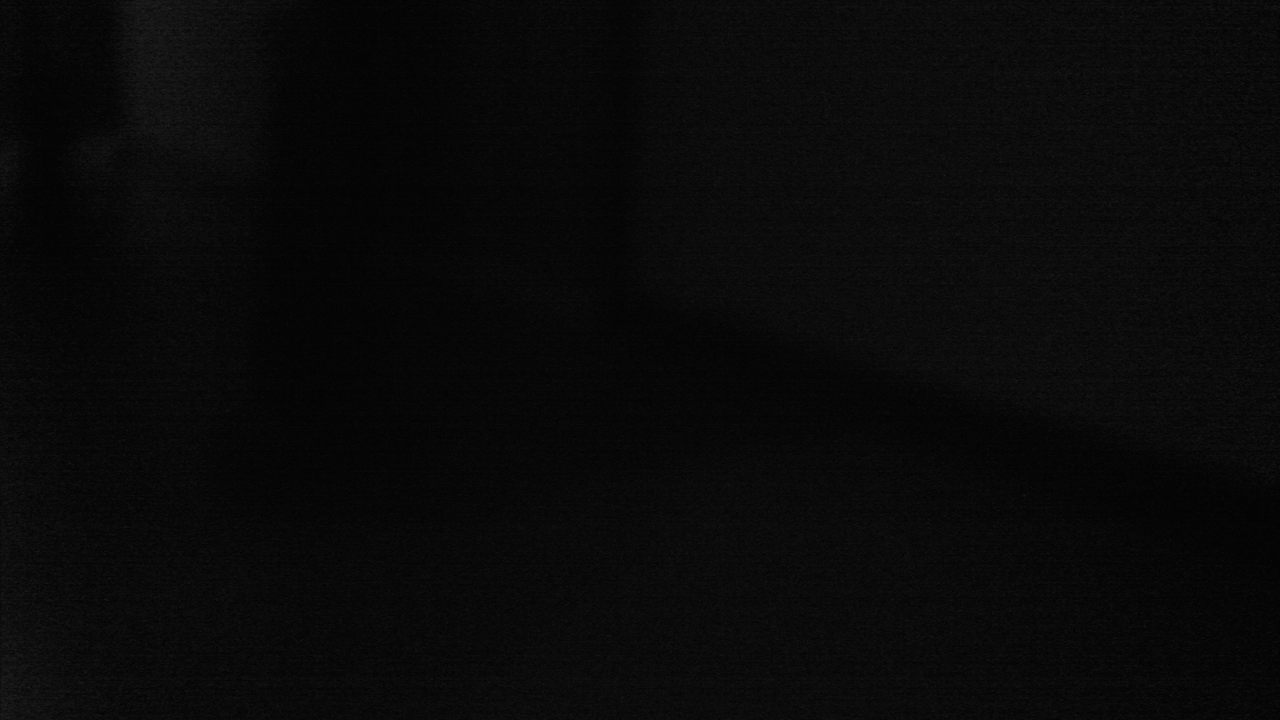

In [5]:
frame = overlay.OV5640.get_frame('gray')
imshow_gray(frame)
frame.freebuffer()

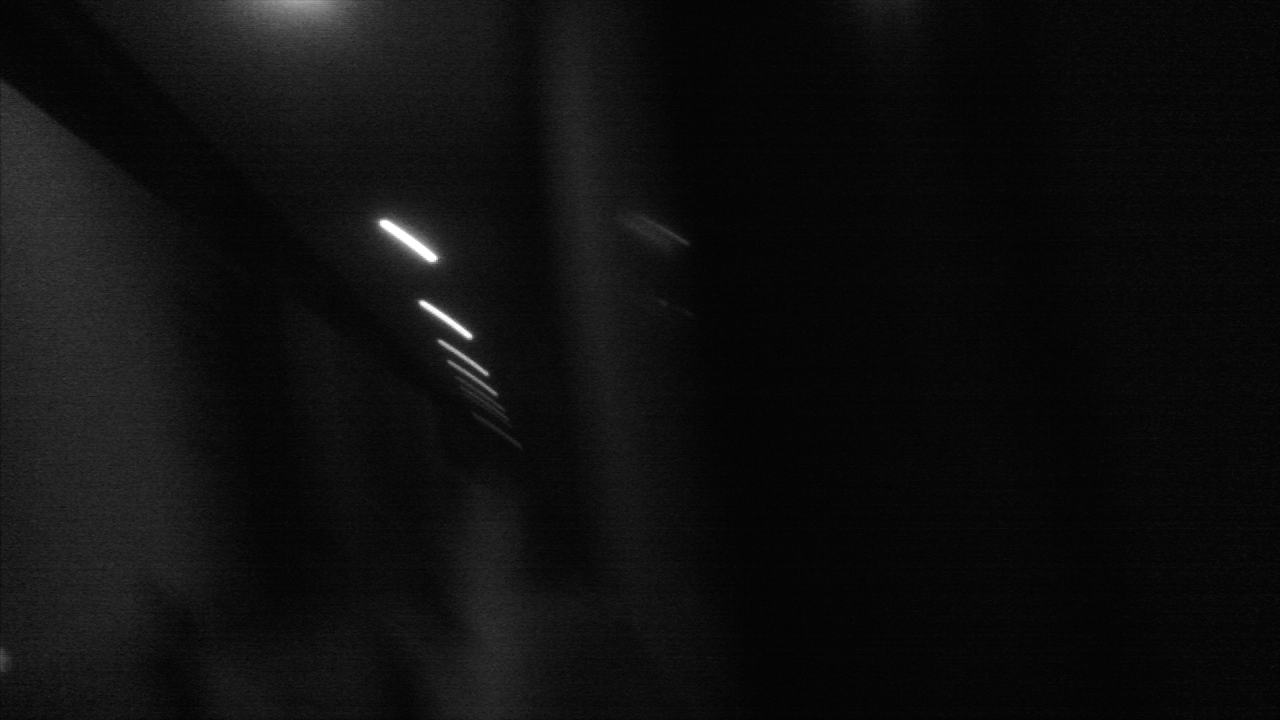

In [6]:
frame = OV5640.get_frame('gray')
res = video_proc.Bypass(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### 主函数

In [63]:
pid = PIDController(kp=0.7, ki=0.01, kd=1.2, output_min=-60, output_max=60)

while True:
    image = overlay.OV5640.get_frame('gray')
    height, width = image.shape[:2]

    #急停二值处理
#     stop_height = height//2 + 70
#     quick_stop = image[0:stop_height, :]
#     ret1, quick_stop = cv2.threshold(quick_stop, 10, 255, cv2.THRESH_BINARY_INV)
#     asd = np.mean(quick_stop)    #判断停止
    
#     image1 = video_proc.Canny(image,30,60)    #边缘处理
    
    #只取中间
    cv_height = height//3
    image = image[2*cv_height:, :]
    #二值化处理
    ret2, image = cv2.threshold(image, 11, 255, cv2.THRESH_BINARY_INV )  #+ cv2.THRESH_OTSU
    
#     imshow_gray(image)      #显示黑白图
    
#     image1 = image1[2*cv_height:, :]  #边缘处理的图像结果取中间
#     image2 = image + image1                    #边缘加二值
    
    #分左，中，右三个区域
    part_width = width // 3
    
    left_part = image[:, 0:part_width]
    middle_part = image[:, part_width:part_width*2]
    right_part = image[:, part_width*2:]
    
#     imshow_gray(image)    #显示处理后的图像

#     a1 = np.count_nonzero(left_part)
#     a2 = np.count_nonzero(middle_part)
#     a3 = np.count_nonzero(right_part)
    #边缘密度
#     density1 = a1 / total_pixels
#     density2 = a2 / total_pixels
#     density3 = a3 / total_pixels
    #平均密度，分辨强边缘，过滤噪声
    avg_intensity1 = np.mean(left_part)
    avg_intensity2 = np.mean(middle_part)
    avg_intensity3 = np.mean(right_part)
    
    #PID误差
    err = avg_intensity1 - avg_intensity3
    output = pid.compute(err)

    print("err:%.2f" %err)
    d = [avg_intensity1,avg_intensity2,avg_intensity3]
    print(d)
#     print("output: %d" %output)
#     print("angle: %d" %angle)
    print('avg_intensity2:%.2f' %avg_intensity2)
    print("asd: %d"%asd)
    
    if 150 < avg_intensity2:
#         #前方有障碍物，需要转向
#         if err < -15:
#             angle = -30  # 左转角度
#         elif err > 15:
#             angle = 30  # 右转角度
        angle = output
    elif  avg_intensity2 <= 30:
        if err < -50:
            angle = -30  # 左转角度
        elif err > 50:
            angle = 30  # 右转角度
        else:
            angle = 0
    else:    # 直行
        angle = 0
    mc.set_direction(angle)
    print("angle: %d" %angle)
    
    #急停
#     if  asd < 1.5:
#         mc.set_velocity(0)
#     elif  asd > 230:
#         mc.set_direction(45)
#     else:
    mc.set_velocity(1000)

err:96.12
[145.13350938967136, 65.433538732394368, 49.016501168224302]
avg_intensity2:65.43
asd: 47
angle: 0
err:98.76
[152.41886737089203, 68.226965962441312, 53.661214953271028]
avg_intensity2:68.23
asd: 47
angle: 0
err:92.43
[142.12808098591549, 62.722417840375584, 49.701664719626166]
avg_intensity2:62.72
asd: 47
angle: 0
err:103.05
[159.6269072769953, 69.90551643192488, 56.578125]
avg_intensity2:69.91
asd: 47
angle: 0
err:96.58
[151.72051056338029, 62.325850938967136, 55.140771028037385]
avg_intensity2:62.33
asd: 47
angle: 0
err:99.87
[158.85871478873239, 64.662852112676063, 58.986127336448597]
avg_intensity2:64.66
asd: 47
angle: 0
err:87.83
[139.52919600938966, 54.566607981220656, 51.702540887850468]
avg_intensity2:54.57
asd: 47
angle: 0
err:101.27
[167.33876173708921, 63.138937793427232, 66.066150700934585]
avg_intensity2:63.14
asd: 47
angle: 0
err:90.31
[150.56073943661971, 53.474178403755872, 60.24970794392523]
avg_intensity2:53.47
asd: 47
angle: 0
err:91.57
[154.93544600938966

err:17.65
[46.630281690140848, 38.639084507042256, 28.975467289719628]
avg_intensity2:38.64
asd: 47
angle: 0
err:-15.13
[51.266872065727696, 25.87661384976526, 66.401285046728972]
avg_intensity2:25.88
asd: 47
angle: 0
err:-34.53
[72.7862382629108, 27.101232394366196, 107.31994742990655]
avg_intensity2:27.10
asd: 47
angle: 0
err:-23.49
[88.170041079812208, 21.369718309859156, 111.66179906542057]
avg_intensity2:21.37
asd: 47
angle: 0
err:5.01
[94.811913145539904, 16.234301643192488, 89.801109813084111]
avg_intensity2:16.23
asd: 47
angle: 0
err:21.84
[90.462147887323937, 23.118104460093896, 68.625584112149539]
avg_intensity2:23.12
asd: 47
angle: 0
err:24.42
[67.875293427230048, 32.229166666666664, 43.455753504672899]
avg_intensity2:32.23
asd: 47
angle: 0
err:23.00
[53.825850938967136, 53.386883802816904, 30.822429906542055]
avg_intensity2:53.39
asd: 47
angle: 0
err:13.06
[28.270980046948356, 56.357394366197184, 15.21509929906542]
avg_intensity2:56.36
asd: 47
angle: 0
err:-6.71
[14.8924589

err:106.21
[120.82071596244131, 62.954372065727696, 14.611857476635514]
avg_intensity2:62.95
asd: 47
angle: 0
err:136.06
[144.01364436619718, 65.164172535211264, 7.9538551401869162]
avg_intensity2:65.16
asd: 47
angle: 0
err:151.09
[154.86062206572771, 53.6612382629108, 3.7733644859813085]
avg_intensity2:53.66
asd: 47
angle: 0
err:150.64
[152.27171361502349, 48.378667840375584, 1.6359521028037383]
avg_intensity2:48.38
asd: 47
angle: 0
err:151.73
[152.53359741784038, 35.541373239436616, 0.80183995327102808]
avg_intensity2:35.54
asd: 47
angle: 0
err:151.16
[151.73547535211267, 33.054724178403752, 0.57345210280373837]
avg_intensity2:33.05
asd: 47
angle: 0
err:122.99
[123.28491784037558, 24.287852112676056, 0.29293224299065418]
avg_intensity2:24.29
asd: 47
angle: 30
err:105.33
[105.58656103286386, 18.104900234741784, 0.25817757009345793]
avg_intensity2:18.10
asd: 47
angle: 30
err:102.74
[102.74325117370893, 15.785357981220658, 0.0049649532710280371]
avg_intensity2:15.79
asd: 47
angle: 30
er

err:-211.28
[19.544014084507044, 51.43397887323944, 230.82316004672896]
avg_intensity2:51.43
asd: 47
angle: 0
err:-212.41
[25.382775821596244, 64.18397887323944, 237.78898948598132]
avg_intensity2:64.18
asd: 47
angle: 0
err:-212.14
[29.118984741784036, 74.806484741784033, 241.25949182242991]
avg_intensity2:74.81
asd: 47
angle: 0
err:-208.36
[35.995305164319248, 88.072769953051647, 244.3601051401869]
avg_intensity2:88.07
asd: 47
angle: 0
err:-211.84
[29.523034037558684, 78.849471830985919, 241.36623831775702]
avg_intensity2:78.85
asd: 47
angle: 0
err:-211.69
[29.069102112676056, 78.487822769953056, 240.75803154205607]
avg_intensity2:78.49
asd: 47
angle: 0
err:-212.52
[27.432951877934272, 75.412558685446015, 239.95619158878506]
avg_intensity2:75.41
asd: 47
angle: 0
err:-209.40
[33.595950704225352, 85.276848591549296, 242.99970794392524]
avg_intensity2:85.28
asd: 47
angle: 0
err:-212.98
[26.0362382629108, 74.282717136150239, 239.01533294392524]
avg_intensity2:74.28
asd: 47
angle: 0
err:-2

err:-114.04
[30.381015258215964, 96.717429577464785, 144.42552570093457]
avg_intensity2:96.72
asd: 47
angle: 0
err:-111.47
[36.085093896713616, 105.53418427230046, 147.55096378504672]
avg_intensity2:105.53
asd: 47
angle: 0
err:-104.27
[30.410944835680752, 89.36722417840376, 134.67683995327104]
avg_intensity2:89.37
asd: 47
angle: 0
err:-104.36
[28.58524061032864, 88.998092723004689, 132.94407126168224]
avg_intensity2:89.00
asd: 47
angle: 0
err:-96.68
[25.864143192488264, 79.974325117370896, 122.54249415887851]
avg_intensity2:79.97
asd: 47
angle: 0
err:-95.42
[33.104606807511736, 90.197769953051647, 128.5252628504673]
avg_intensity2:90.20
asd: 47
angle: 0
err:-94.17
[36.284624413145536, 96.323356807511743, 130.45662967289721]
avg_intensity2:96.32
asd: 47
angle: 0
err:-91.49
[38.89598004694836, 95.667400234741791, 130.3846378504673]
avg_intensity2:95.67
asd: 47
angle: 0
err:-101.73
[33.169454225352112, 84.171948356807505, 134.89778037383178]
avg_intensity2:84.17
asd: 47
angle: 0
err:-122.

err:-105.80
[4.095363849765258, 38.67899061032864, 109.89924065420561]
avg_intensity2:38.68
asd: 47
angle: 0
err:-98.27
[4.481954225352113, 36.895686619718312, 102.75467289719626]
avg_intensity2:36.90
asd: 47
angle: 0
err:-100.01
[5.083039906103286, 39.911091549295776, 105.09068341121495]
avg_intensity2:39.91
asd: 47
angle: 0
err:-92.11
[4.5168720657276999, 35.182218309859152, 96.625438084112147]
avg_intensity2:35.18
asd: 47
angle: 0
err:-98.94
[8.068515258215962, 49.029636150234744, 107.01212032710281]
avg_intensity2:49.03
asd: 47
angle: 0
err:-100.44
[4.2275528169014081, 35.301936619718312, 104.67114485981308]
avg_intensity2:35.30
asd: 47
angle: 0
err:-132.21
[2.9181338028169015, 41.060886150234744, 135.13113317757009]
avg_intensity2:41.06
asd: 47
angle: 0
err:-161.02
[0.99765258215962438, 35.950410798122064, 162.0163551401869]
avg_intensity2:35.95
asd: 47
angle: 0
err:-186.54
[0.47637910798122068, 40.257775821596248, 187.01985981308411]
avg_intensity2:40.26
asd: 47
angle: 0
err:-188

err:-95.90
[20.7162558685446, 2.3968603286384975, 116.61930490654206]
avg_intensity2:2.40
asd: 47
angle: -30
err:-50.08
[28.921948356807512, 2.0152582159624415, 79.00481892523365]
avg_intensity2:2.02
asd: 47
angle: -30
err:-21.83
[37.369571596244128, 2.1449530516431925, 59.20210280373832]
avg_intensity2:2.14
asd: 47
angle: 0
err:-6.29
[48.318808685446008, 2.940580985915493, 54.609521028037385]
avg_intensity2:2.94
asd: 47
angle: 0
err:2.98
[42.854166666666664, 3.032863849765258, 39.873539719626166]
avg_intensity2:3.03
asd: 47
angle: 0
err:8.96
[44.779636150234744, 5.033157276995305, 35.822137850467293]
avg_intensity2:5.03
asd: 47
angle: 0
err:15.18
[42.4975058685446, 5.277582159624413, 27.317172897196262]
avg_intensity2:5.28
asd: 47
angle: 0
err:20.33
[49.18676643192488, 6.95862676056338, 28.858790887850468]
avg_intensity2:6.96
asd: 47
angle: 0
err:21.63
[42.215669014084504, 5.756455399061033, 20.589661214953271]
avg_intensity2:5.76
asd: 47
angle: 0
err:25.19
[44.677376760563384, 6.8289

err:-51.22
[13.36355633802817, 9.594923708920188, 64.579147196261687]
avg_intensity2:9.59
asd: 47
angle: -30
err:-63.18
[18.149794600938968, 14.992224178403756, 81.333382009345797]
avg_intensity2:14.99
asd: 47
angle: -30
err:-59.59
[12.762470657276996, 13.982100938967136, 72.356746495327101]
avg_intensity2:13.98
asd: 47
angle: -30
err:-54.88
[8.9539319248826299, 13.488262910798122, 63.836886682242991]
avg_intensity2:13.49
asd: 47
angle: -30
err:-53.93
[8.1932218309859159, 14.413585680751174, 62.12397780373832]
avg_intensity2:14.41
asd: 47
angle: -30
err:-50.62
[9.8667840375586859, 15.216696009389672, 60.490508177570092]
avg_intensity2:15.22
asd: 47
angle: -30
err:-49.80
[12.071596244131456, 16.321596244131456, 61.868282710280376]
avg_intensity2:16.32
asd: 47
angle: 0
err:-47.36
[11.84712441314554, 14.179137323943662, 59.212032710280376]
avg_intensity2:14.18
asd: 47
angle: 0
err:-63.79
[23.549589201877936, 24.579665492957748, 87.336010514018696]
avg_intensity2:24.58
asd: 47
angle: -30
e

err:-13.74
[2.254694835680751, 0.32174295774647887, 15.994596962616823]
avg_intensity2:0.32
asd: 47
angle: 0
err:-15.60
[3.875880281690141, 0.33920187793427231, 19.472546728971963]
avg_intensity2:0.34
asd: 47
angle: 0
err:-15.91
[4.980780516431925, 0.38160211267605632, 20.895005841121495]
avg_intensity2:0.38
asd: 47
angle: 0
err:-12.12
[7.5821596244131459, 0.66343896713615025, 19.703417056074766]
avg_intensity2:0.66
asd: 47
angle: 0
err:-6.57
[6.893779342723005, 0.613556338028169, 13.462470794392523]
avg_intensity2:0.61
asd: 47
angle: 0
err:0.28
[7.282863849765258, 0.45892018779342725, 7.003066588785047]
avg_intensity2:0.46
asd: 47
angle: 0
err:3.06
[10.30824530516432, 0.91285211267605637, 7.2463492990654208]
avg_intensity2:0.91
asd: 47
angle: 0
err:7.55
[14.443515258215962, 1.7109741784037558, 6.8963200934579438]
avg_intensity2:1.71
asd: 47
angle: 0
err:9.64
[13.665346244131456, 1.795774647887324, 4.0265771028037385]
avg_intensity2:1.80
asd: 47
angle: 0
err:14.35
[17.458920187793428, 

err:-29.79
[52.830692488262912, 18.942928403755868, 82.616822429906549]
avg_intensity2:18.94
asd: 47
angle: 0
err:-31.21
[59.240610328638496, 21.7787558685446, 90.44655373831776]
avg_intensity2:21.78
asd: 47
angle: 0
err:-32.18
[65.473444835680752, 25.87411971830986, 97.650700934579433]
avg_intensity2:25.87
asd: 47
angle: 0
err:-31.38
[54.137617370892016, 19.676203051643192, 85.513872663551396]
avg_intensity2:19.68
asd: 47
angle: 0
err:-32.13
[64.585534037558688, 24.951291079812208, 96.719772196261687]
avg_intensity2:24.95
asd: 47
angle: 0
err:-28.62
[46.630281690140848, 17.207012910798124, 75.248831775700936]
avg_intensity2:17.21
asd: 47
angle: 0
err:-29.11
[50.306631455399064, 17.738262910798124, 79.419392523364479]
avg_intensity2:17.74
asd: 47
angle: 0
err:-30.44
[55.601672535211264, 19.97549882629108, 86.042640186915889]
avg_intensity2:19.98
asd: 47
angle: 0
err:-31.86
[52.239583333333336, 18.521420187793428, 84.103825934579433]
avg_intensity2:18.52
asd: 47
angle: 0
err:-32.77
[55.

err:-2.36
[47.563086854460096, 7.430017605633803, 49.925087616822431]
avg_intensity2:7.43
asd: 47
angle: 0
err:-10.77
[55.117811032863848, 9.7894659624413141, 65.887412383177576]
avg_intensity2:9.79
asd: 47
angle: 0
err:-12.56
[40.656836854460096, 6.579518779342723, 53.211886682242991]
avg_intensity2:6.58
asd: 47
angle: 0
err:-15.71
[47.767605633802816, 8.5823063380281699, 63.481892523364486]
avg_intensity2:8.58
asd: 47
angle: 0
err:-14.26
[52.725938967136152, 11.325850938967136, 66.987149532710276]
avg_intensity2:11.33
asd: 47
angle: 0
err:-5.45
[44.707306338028168, 8.6097417840375581, 50.153475467289717]
avg_intensity2:8.61
asd: 47
angle: 0
err:6.77
[39.766431924882632, 7.4150528169014081, 32.994596962616825]
avg_intensity2:7.42
asd: 47
angle: 0
err:22.40
[44.42048122065728, 8.998826291079812, 22.022050233644858]
avg_intensity2:9.00
asd: 47
angle: 0
err:27.32
[38.55927230046948, 8.914025821596244, 11.240654205607477]
avg_intensity2:8.91
asd: 47
angle: 0
err:25.67
[33.615903755868544,

err:124.42
[192.12544014084506, 127.93647300469483, 67.709550233644862]
avg_intensity2:127.94
asd: 47
angle: 0
err:125.09
[185.83274647887325, 116.16417253521126, 60.746203271028037]
avg_intensity2:116.16
asd: 47
angle: 0
err:128.17
[208.28491784037558, 146.42796361502349, 80.112003504672899]
avg_intensity2:146.43
asd: 47
angle: 0
err:130.26
[206.3843896713615, 142.30765845070422, 76.127628504672899]
avg_intensity2:142.31
asd: 47
angle: 0
err:132.19
[216.49559859154928, 153.47388497652582, 84.304906542056074]
avg_intensity2:153.47
asd: 47
angle: -60
err:134.07
[218.68544600938966, 154.76335093896714, 84.617698598130843]
avg_intensity2:154.76
asd: 47
angle: -60
err:130.66
[227.57951877934272, 169.1794307511737, 96.918370327102807]
avg_intensity2:169.18
asd: 47
angle: -60
err:125.70
[228.36766431924883, 168.59330985915494, 102.66530373831776]
avg_intensity2:168.59
asd: 47
angle: -60
err:128.42
[226.02567488262912, 155.9380868544601, 97.603533878504678]
avg_intensity2:155.94
asd: 47
angle

err:-31.80
[146.87940140845072, 105.67884389671362, 178.68370327102804]
avg_intensity2:105.68
asd: 47
angle: 0
err:-34.08
[139.4793133802817, 100.04709507042253, 173.55490654205607]
avg_intensity2:100.05
asd: 47
angle: 0
err:-31.69
[143.15067488262912, 100.88761737089202, 174.83834696261681]
avg_intensity2:100.89
asd: 47
angle: 0
err:-35.24
[139.1875, 98.253814553990608, 174.42873831775702]
avg_intensity2:98.25
asd: 47
angle: 0
err:-35.75
[136.61854460093898, 97.296068075117375, 172.36580023364485]
avg_intensity2:97.30
asd: 47
angle: 0
err:-34.31
[147.77479460093898, 107.71156103286386, 182.08717873831776]
avg_intensity2:107.71
asd: 47
angle: 0
err:-35.25
[143.23048708920189, 102.75073356807512, 178.48014018691589]
avg_intensity2:102.75
asd: 47
angle: 0
err:-30.66
[145.87676056338029, 103.81323356807512, 176.53636098130841]
avg_intensity2:103.81
asd: 47
angle: 0
err:-30.24
[130.6775234741784, 88.61150234741784, 160.9166179906542]
avg_intensity2:88.61
asd: 47
angle: 0
err:-28.63
[125.77

err:-11.47
[243.32497065727699, 253.86267605633802, 254.79395443925233]
avg_intensity2:253.86
asd: 47
angle: -60
err:-17.89
[236.77787558685446, 252.59066901408451, 254.66486565420561]
avg_intensity2:252.59
asd: 47
angle: -60
err:-13.59
[238.2718603286385, 246.27303403755869, 251.85718457943926]
avg_intensity2:246.27
asd: 47
angle: -60
err:-0.73
[250.4906103286385, 247.0711561032864, 251.22415303738319]
avg_intensity2:247.07
asd: 47
angle: -60
err:0.51
[251.30868544600938, 246.10093896713616, 250.79716705607476]
avg_intensity2:246.10
asd: 47
angle: -60
err:0.41
[250.80487089201878, 245.40258215962442, 250.39004088785046]
avg_intensity2:245.40
asd: 47
angle: -60
err:0.70
[251.18148474178403, 245.59961854460093, 250.48189252336448]
avg_intensity2:245.60
asd: 47
angle: -60
err:1.12
[251.15404929577466, 245.14069835680752, 250.03752920560748]
avg_intensity2:245.14
asd: 47
angle: -60
err:1.43
[251.38350938967136, 246.14333920187792, 249.953125]
avg_intensity2:246.14
asd: 47
angle: -60
err:2

err:-135.80
[59.17825704225352, 140.81616784037558, 194.97619742990653]
avg_intensity2:140.82
asd: 47
angle: 0
err:-129.77
[69.0674882629108, 150.74281103286384, 198.83396612149534]
avg_intensity2:150.74
asd: 47
angle: -60
err:-135.39
[59.248092723004696, 142.99853286384976, 194.63609813084113]
avg_intensity2:143.00
asd: 47
angle: 0
err:-128.33
[70.97799295774648, 150.96229460093898, 199.3081191588785]
avg_intensity2:150.96
asd: 47
angle: -60
err:-126.51
[76.073503521126767, 157.69894366197184, 202.58747079439252]
avg_intensity2:157.70
asd: 47
angle: -60
err:-128.03
[77.298122065727696, 160.76423122065728, 205.32564252336448]
avg_intensity2:160.76
asd: 47
angle: -60
err:-145.42
[51.074823943661968, 136.2718603286385, 196.49299065420561]
avg_intensity2:136.27
asd: 47
angle: 0
err:-135.45
[71.212441314553985, 159.60944835680752, 206.65873247663552]
avg_intensity2:159.61
asd: 47
angle: -60
err:-141.14
[62.672535211267608, 154.3418427230047, 203.81133177570092]
avg_intensity2:154.34
asd: 4

err:101.66
[195.27053990610329, 119.19204812206573, 93.611711448598129]
avg_intensity2:119.19
asd: 47
angle: 0
err:93.53
[197.96420187793427, 130.31587441314554, 104.43779205607477]
avg_intensity2:130.32
asd: 47
angle: 0
err:62.21
[155.46170774647888, 106.5418133802817, 93.246787383177576]
avg_intensity2:106.54
asd: 47
angle: 0
err:76.60
[189.00777582159625, 133.0519366197183, 112.40405957943925]
avg_intensity2:133.05
asd: 47
angle: 0
err:62.21
[155.46170774647888, 106.5418133802817, 93.246787383177576]
avg_intensity2:106.54
asd: 47
angle: 0
err:89.30
[201.95730633802816, 128.99647887323943, 112.65478971962617]
avg_intensity2:129.00
asd: 47
angle: 0
err:106.12
[220.53609154929578, 138.0850938967136, 114.41238317757009]
avg_intensity2:138.09
asd: 47
angle: 0
err:116.76
[236.76540492957747, 166.01687206572771, 120.00292056074767]
avg_intensity2:166.02
asd: 47
angle: -60
err:122.92
[234.33612089201878, 157.99574530516432, 111.41603387850468]
avg_intensity2:158.00
asd: 47
angle: -60
err:12

err:-28.05
[171.0625, 200.15654342723005, 199.11696845794393]
avg_intensity2:200.16
asd: 47
angle: -60
err:-38.08
[163.3631161971831, 195.43515258215962, 201.44056658878506]
avg_intensity2:195.44
asd: 47
angle: -60
err:-46.19
[158.45466549295776, 193.69923708920189, 204.64296144859813]
avg_intensity2:193.70
asd: 47
angle: -60
err:-52.45
[154.72593896713616, 194.7268192488263, 207.1726051401869]
avg_intensity2:194.73
asd: 47
angle: -60
err:-60.46
[144.62470657276995, 183.60049882629107, 205.08235981308411]
avg_intensity2:183.60
asd: 47
angle: -60
err:-58.19
[156.49427816901408, 199.06161971830986, 214.68706191588785]
avg_intensity2:199.06
asd: 47
angle: -60
err:-64.03
[147.15126173708921, 184.92737676056339, 211.18180490654206]
avg_intensity2:184.93
asd: 47
angle: -60
err:-53.82
[165.42077464788733, 196.44278169014083, 219.24488901869159]
avg_intensity2:196.44
asd: 47
angle: -60
err:-46.41
[175.52450117370893, 199.43324530516432, 221.93092873831776]
avg_intensity2:199.43
asd: 47
angle: 

err:-31.45
[174.12778755868544, 169.69821009389671, 205.5788551401869]
avg_intensity2:169.70
asd: 47
angle: -60
err:-32.50
[173.71625586854461, 173.81602112676057, 206.2143691588785]
avg_intensity2:173.82
asd: 47
angle: -60
err:-42.73
[158.47212441314554, 165.35842136150234, 201.19728387850466]
avg_intensity2:165.36
asd: 47
angle: -60
err:-30.01
[176.17796361502349, 185.70055751173709, 206.19202686915887]
avg_intensity2:185.70
asd: 47
angle: -60
err:-13.14
[187.80809859154928, 180.40801056338029, 200.94407126168224]
avg_intensity2:180.41
asd: 47
angle: -60
err:-8.46
[195.07849178403757, 185.05208333333334, 203.54322429906543]
avg_intensity2:185.05
asd: 47
angle: -60
err:-35.97
[158.69160798122067, 170.64847417840375, 194.66092289719626]
avg_intensity2:170.65
asd: 47
angle: -60
err:-29.24
[169.05472417840375, 182.33348004694835, 198.29278621495328]
avg_intensity2:182.33
asd: 47
angle: -60
err:-33.42
[161.89656690140845, 179.2731807511737, 195.31877920560748]
avg_intensity2:179.27
asd: 4

err:-4.04
[158.38482981220656, 199.95950704225353, 162.42844626168224]
avg_intensity2:199.96
asd: 47
angle: -60
err:-4.75
[160.30032276995306, 201.51833920187792, 165.05490654205607]
avg_intensity2:201.52
asd: 47
angle: -60
err:-9.94
[151.59580399061034, 191.89847417840375, 161.5372371495327]
avg_intensity2:191.90
asd: 47
angle: -60
err:-1.78
[164.6675469483568, 199.77494131455398, 166.45254088785046]
avg_intensity2:199.77
asd: 47
angle: -60
err:2.50
[171.04753521126761, 202.82775821596243, 168.54526869158877]
avg_intensity2:202.83
asd: 47
angle: -60
err:-13.40
[141.5544307511737, 179.48518192488262, 154.95867406542055]
avg_intensity2:179.49
asd: 47
angle: -60
err:-4.22
[157.7513204225352, 192.66417253521126, 161.97415303738319]
avg_intensity2:192.66
asd: 47
angle: -60
err:-2.65
[167.40360915492957, 200.23635563380282, 170.05709696261681]
avg_intensity2:200.24
asd: 47
angle: -60
err:-13.73
[145.5225938967136, 181.67253521126761, 159.25335864485982]
avg_intensity2:181.67
asd: 47
angle: 

err:23.56
[188.90551643192489, 198.83964201877933, 165.34535630841123]
avg_intensity2:198.84
asd: 47
angle: -60
err:27.89
[186.1769366197183, 196.25073356807511, 158.28271028037383]
avg_intensity2:196.25
asd: 47
angle: -60
err:29.60
[181.93192488262912, 196.3006161971831, 152.32724883177571]
avg_intensity2:196.30
asd: 47
angle: -60
err:43.10
[194.7168427230047, 204.66343896713616, 151.61229556074767]
avg_intensity2:204.66
asd: 47
angle: -60
err:47.56
[186.21185446009389, 200.34360328638499, 138.65625]
avg_intensity2:200.34
asd: 47
angle: -60
err:60.23
[191.51687206572771, 204.34169600938966, 131.28577686915887]
avg_intensity2:204.34
asd: 47
angle: -60
err:68.89
[182.54548122065728, 197.87191901408451, 113.65522780373831]
avg_intensity2:197.87
asd: 47
angle: -60
err:92.65
[209.54445422535213, 219.84022887323943, 116.89734228971963]
avg_intensity2:219.84
asd: 47
angle: -60
err:98.41
[191.91842723004694, 208.83362676056339, 93.507447429906549]
avg_intensity2:208.83
asd: 47
angle: -60
err:

err:68.34
[162.52508802816902, 196.87676056338029, 94.185163551401871]
avg_intensity2:196.88
asd: 47
angle: -60
err:74.24
[170.66094483568074, 197.53022300469485, 96.416910046728972]
avg_intensity2:197.53
asd: 47
angle: -60
err:75.39
[170.16960093896714, 194.48987676056339, 94.775992990654203]
avg_intensity2:194.49
asd: 47
angle: -60
err:78.39
[177.62206572769952, 199.73503521126761, 99.237003504672899]
avg_intensity2:199.74
asd: 47
angle: -60
err:78.24
[183.30619131455398, 204.63350938967136, 105.07082359813084]
avg_intensity2:204.63
asd: 47
angle: -60
err:69.74
[169.60093896713616, 193.29269366197184, 99.865070093457945]
avg_intensity2:193.29
asd: 47
angle: -60
err:73.28
[177.24794600938966, 198.35328638497651, 103.9661214953271]
avg_intensity2:198.35
asd: 47
angle: -60
err:77.03
[181.72241784037558, 198.59022887323943, 104.68852219626169]
avg_intensity2:198.59
asd: 47
angle: -60
err:71.19
[169.99251760563379, 188.50645539906102, 98.797605140186917]
avg_intensity2:188.51
asd: 47
angl

err:70.65
[181.53286384976525, 189.29709507042253, 110.88230140186916]
avg_intensity2:189.30
asd: 47
angle: -60
err:70.73
[181.61018192488262, 188.8631161971831, 110.88478387850468]
avg_intensity2:188.86
asd: 47
angle: -60
err:72.72
[187.43647300469485, 195.69204812206573, 114.71772780373831]
avg_intensity2:195.69
asd: 47
angle: -60
err:63.07
[173.31470070422534, 184.76525821596243, 110.24678738317758]
avg_intensity2:184.77
asd: 47
angle: -60
err:63.38
[174.01305751173709, 183.06426056338029, 110.62908878504673]
avg_intensity2:183.06
asd: 47
angle: -60
err:62.69
[180.46288145539907, 188.80575117370893, 117.77613901869159]
avg_intensity2:188.81
asd: 47
angle: -60
err:54.42
[161.59477699530515, 173.19498239436621, 107.17596378504673]
avg_intensity2:173.19
asd: 47
angle: -60
err:62.98
[174.35724765258215, 182.2087734741784, 111.38127920560747]
avg_intensity2:182.21
asd: 47
angle: -60
err:65.84
[180.53022300469485, 187.64598004694835, 114.68545560747664]
avg_intensity2:187.65
asd: 47
angle

err:65.00
[182.52303403755869, 190.63394953051642, 117.52540887850468]
avg_intensity2:190.63
asd: 47
angle: -60
err:65.41
[186.83538732394365, 194.79914906103286, 121.42537967289719]
avg_intensity2:194.80
asd: 47
angle: -60
err:55.92
[171.5538438967136, 181.9493838028169, 115.63127920560747]
avg_intensity2:181.95
asd: 47
angle: -60
err:44.24
[154.08744131455398, 167.30633802816902, 109.84959112149532]
avg_intensity2:167.31
asd: 47
angle: -60
err:53.35
[171.47153755868544, 183.22139084507043, 118.12616822429906]
avg_intensity2:183.22
asd: 47
angle: -60
err:58.63
[183.0093896713615, 191.36223591549296, 124.37456191588785]
avg_intensity2:191.36
asd: 47
angle: -60
err:54.64
[174.79621478873239, 182.39084507042253, 120.15435163551402]
avg_intensity2:182.39
asd: 47
angle: -60
err:52.26
[171.95539906103286, 180.04386737089203, 119.70005841121495]
avg_intensity2:180.04
asd: 47
angle: -60
err:62.93
[192.12544014084506, 198.19116784037558, 129.19304906542055]
avg_intensity2:198.19
asd: 47
angle:

err:64.20
[180.03638497652582, 181.38820422535213, 115.83235981308411]
avg_intensity2:181.39
asd: 47
angle: -42
err:65.21
[183.94967723004694, 186.03726525821597, 118.74182242990655]
avg_intensity2:186.04
asd: 47
angle: -35
err:62.33
[175.91109154929578, 175.75894953051642, 113.58323598130841]
avg_intensity2:175.76
asd: 47
angle: -41
err:64.73
[183.29621478873239, 184.99970657276995, 118.56556658878505]
avg_intensity2:185.00
asd: 47
angle: -32
err:61.27
[178.07100938967136, 181.08890845070422, 116.79804322429906]
avg_intensity2:181.09
asd: 47
angle: -41
err:58.85
[178.7519072769953, 184.98224765258215, 119.9036214953271]
avg_intensity2:184.98
asd: 47
angle: -41
err:68.38
[193.00586854460093, 196.50762910798122, 124.62529205607477]
avg_intensity2:196.51
asd: 47
angle: -19
err:62.52
[181.62764084507043, 188.22960680751174, 119.10922897196262]
avg_intensity2:188.23
asd: 47
angle: -41
err:64.73
[186.18441901408451, 191.22755281690141, 121.45268691588785]
avg_intensity2:191.23
asd: 47
angle

err:8.00
[142.56954225352112, 196.46273474178403, 134.57257593457945]
avg_intensity2:196.46
asd: 47
angle: -50
err:-4.75
[125.40991784037558, 186.91519953051642, 130.16369742990653]
avg_intensity2:186.92
asd: 47
angle: -60
err:-9.89
[124.95099765258216, 191.05296361502349, 134.84068341121494]
avg_intensity2:191.05
asd: 47
angle: -60
err:-20.30
[110.98136737089202, 181.49794600938966, 131.28081191588785]
avg_intensity2:181.50
asd: 47
angle: -60
err:-13.81
[121.59639084507042, 180.39803403755869, 135.40420560747663]
avg_intensity2:180.40
asd: 47
angle: -57
err:-61.82
[76.549882629107984, 168.01716549295776, 138.36580023364485]
avg_intensity2:168.02
asd: 47
angle: -60
err:-49.02
[85.875440140845072, 169.81294014084506, 134.9002628504673]
avg_intensity2:169.81
asd: 47
angle: -60
err:-29.63
[105.62397300469483, 186.82291666666666, 135.25277453271028]
avg_intensity2:186.82
asd: 47
angle: -54
err:-16.75
[121.9480633802817, 201.57071596244131, 138.69845210280374]
avg_intensity2:201.57
asd: 47


err:50.48
[228.52230046948358, 133.21904342723005, 178.04322429906543]
avg_intensity2:133.22
asd: 47
angle: 0
err:48.84
[227.07071596244131, 127.47755281690141, 178.22692757009347]
avg_intensity2:127.48
asd: 47
angle: 0
err:46.98
[226.99589201877933, 125.9162265258216, 180.01927570093457]
avg_intensity2:125.92
asd: 47
angle: 0
err:47.96
[223.03770539906102, 116.90742370892019, 175.07418224299064]
avg_intensity2:116.91
asd: 47
angle: 0
err:46.65
[226.99339788732394, 121.30208333333333, 180.34696261682242]
avg_intensity2:121.30
asd: 47
angle: 0
err:47.55
[228.75674882629107, 119.72329812206573, 181.2083820093458]
avg_intensity2:119.72
asd: 47
angle: 0
err:48.38
[229.7618838028169, 118.04474765258216, 181.37719042056074]
avg_intensity2:118.04
asd: 47
angle: 0
err:50.68
[234.86238262910797, 120.66607981220658, 184.18487149532712]
avg_intensity2:120.67
asd: 47
angle: 0
err:53.93
[233.86473004694835, 114.91960093896714, 179.93238901869159]
avg_intensity2:114.92
asd: 47
angle: 0
err:55.49
[23

err:-23.74
[106.98576877934272, 51.0024941314554, 130.7247371495327]
avg_intensity2:51.00
asd: 47
angle: 0
err:-21.15
[100.08201291079813, 46.201291079812208, 121.22926401869159]
avg_intensity2:46.20
asd: 47
angle: 0
err:-21.02
[116.44351525821597, 57.68926056338028, 137.46714369158877]
avg_intensity2:57.69
asd: 47
angle: 0
err:-19.86
[96.318368544600943, 43.88673708920188, 116.17494158878505]
avg_intensity2:43.89
asd: 47
angle: 0
err:-18.56
[94.535064553990608, 40.449823943661968, 113.09170560747664]
avg_intensity2:40.45
asd: 47
angle: 0
err:-18.02
[119.37910798122066, 57.868838028169016, 137.40011682242991]
avg_intensity2:57.87
asd: 47
angle: 0
err:-23.58
[114.94953051643192, 53.86575704225352, 138.52716121495328]
avg_intensity2:53.87
asd: 47
angle: 0
err:-68.96
[112.3281983568075, 52.80824530516432, 181.28782126168224]
avg_intensity2:52.81
asd: 47
angle: 0
err:-128.71
[93.589788732394368, 64.847417840375584, 222.30330023364485]
avg_intensity2:64.85
asd: 47
angle: 0
err:-109.37
[95.6

err:-6.67
[239.99281103286384, 239.96038732394365, 246.66136098130841]
avg_intensity2:239.96
asd: 47
angle: 19
err:-4.93
[241.37705399061034, 239.10490023474179, 246.30636682242991]
avg_intensity2:239.10
asd: 47
angle: 20
err:-2.74
[243.31499413145539, 239.64363262910797, 246.0581191588785]
avg_intensity2:239.64
asd: 47
angle: 22
err:-1.14
[245.93383215962442, 240.99046361502349, 247.07096962616822]
avg_intensity2:240.99
asd: 47
angle: 22
err:-0.12
[246.45759976525821, 239.98532863849766, 246.58192172897196]
avg_intensity2:239.99
asd: 47
angle: 22
err:0.46
[246.98635563380282, 239.89553990610329, 246.52482476635515]
avg_intensity2:239.90
asd: 47
angle: 22
err:1.20
[250.50557511737088, 244.37998826291079, 249.30768107476635]
avg_intensity2:244.38
asd: 47
angle: 23
err:1.12
[251.0193661971831, 245.46493544600938, 249.89851051401868]
avg_intensity2:245.46
asd: 47
angle: 22
err:1.67
[250.32100938967136, 243.43970070422534, 248.65230724299064]
avg_intensity2:243.44
asd: 47
angle: 23
err:2.3

err:-29.92
[218.04694835680752, 234.68031103286384, 247.96714369158877]
avg_intensity2:234.68
asd: 47
angle: -1
err:-25.35
[223.04768192488262, 236.27406103286384, 248.40157710280374]
avg_intensity2:236.27
asd: 47
angle: 7
err:-16.66
[232.75982981220656, 240.3644366197183, 249.41939252336448]
avg_intensity2:240.36
asd: 47
angle: 18
err:-10.62
[237.33406690140845, 239.44659624413146, 247.95473130841123]
avg_intensity2:239.45
asd: 47
angle: 19
err:-6.29
[240.25968309859155, 237.23679577464787, 246.54468457943926]
avg_intensity2:237.24
asd: 47
angle: 20
err:-2.40
[246.31044600938966, 241.7087734741784, 248.70940420560748]
avg_intensity2:241.71
asd: 47
angle: 22
err:0.22
[247.5425469483568, 240.06015258215962, 247.32169976635515]
avg_intensity2:240.06
asd: 47
angle: 22
err:0.84
[249.39319248826291, 242.94835680751174, 248.55797313084113]
avg_intensity2:242.95
asd: 47
angle: 20
err:1.62
[251.20143779342723, 244.95363849765258, 249.58571845794393]
avg_intensity2:244.95
asd: 47
angle: 21
err:

err:-116.76
[128.8119131455399, 126.10827464788733, 245.56907126168224]
avg_intensity2:126.11
asd: 47
angle: 0
err:-106.12
[141.95848004694835, 145.49017018779344, 248.07389018691589]
avg_intensity2:145.49
asd: 47
angle: 0
err:-114.46
[132.3211561032864, 148.93705985915494, 246.78548481308411]
avg_intensity2:148.94
asd: 47
angle: 0
err:-112.77
[133.15669014084506, 156.82100938967136, 245.9315128504673]
avg_intensity2:156.82
asd: 47
angle: -60
err:-88.11
[163.0737969483568, 173.78359741784038, 251.17946845794393]
avg_intensity2:173.78
asd: 47
angle: -40
err:-88.33
[162.88923122065728, 165.91710680751174, 251.21670560747663]
avg_intensity2:165.92
asd: 47
angle: -60
err:-67.36
[184.11428990610329, 169.41637323943661, 251.47240070093457]
avg_intensity2:169.42
asd: 47
angle: -31
err:-50.08
[200.06426056338029, 167.25645539906102, 250.14675817757009]
avg_intensity2:167.26
asd: 47
angle: -24
err:-37.35
[209.69160798122067, 164.86707746478874, 247.04117990654206]
avg_intensity2:164.87
asd: 47


err:-1.33
[252.48840962441315, 251.82497065727699, 253.81585864485982]
avg_intensity2:251.82
asd: 47
angle: -15
err:-3.66
[249.35328638497651, 250.12896126760563, 253.01650116822429]
avg_intensity2:250.13
asd: 47
angle: -19
err:-5.54
[247.65478286384976, 250.50557511737088, 253.1927570093458]
avg_intensity2:250.51
asd: 47
angle: -20
err:-5.14
[247.60490023474179, 249.9269366197183, 252.74839369158877]
avg_intensity2:249.93
asd: 47
angle: -17
err:-3.14
[250.56294014084506, 251.77009976525821, 253.69918224299064]
avg_intensity2:251.77
asd: 47
angle: -13
err:-2.82
[250.96698943661971, 251.86986502347418, 253.78606892523365]
avg_intensity2:251.87
asd: 47
angle: -15
err:-4.50
[249.19116784037558, 251.58054577464787, 253.69173481308411]
avg_intensity2:251.58
asd: 47
angle: -19
err:-2.22
[252.23899647887325, 253.44865023474179, 254.46130257009347]
avg_intensity2:253.45
asd: 47
angle: -13
err:-3.60
[250.25366784037558, 251.97711267605635, 253.85557827102804]
avg_intensity2:251.98
asd: 47
angle

err:89.78
[237.58597417840375, 221.63600352112675, 147.80169392523365]
avg_intensity2:221.64
asd: 47
angle: 60
err:87.95
[240.59389671361501, 227.93867370892019, 152.64004088785046]
avg_intensity2:227.94
asd: 47
angle: 60
err:91.26
[240.9256161971831, 226.75645539906102, 149.66106892523365]
avg_intensity2:226.76
asd: 47
angle: 60
err:97.94
[230.52758215962442, 213.85680751173709, 132.58659462616822]
avg_intensity2:213.86
asd: 47
angle: 60
err:93.24
[238.45892018779344, 223.62881455399062, 145.21991822429908]
avg_intensity2:223.63
asd: 47
angle: 60
err:96.27
[238.5611795774648, 223.69116784037558, 142.29059579439252]
avg_intensity2:223.69
asd: 47
angle: 60
err:93.21
[235.36120892018781, 221.25440140845072, 142.15157710280374]
avg_intensity2:221.25
asd: 47
angle: 60
err:96.15
[237.04225352112675, 224.09771126760563, 140.89544392523365]
avg_intensity2:224.10
asd: 47
angle: 60
err:92.81
[238.89289906103286, 229.49501173708921, 146.08133761682242]
avg_intensity2:229.50
asd: 47
angle: 60
err

err:130.42
[251.99706572769952, 204.11971830985917, 121.58177570093459]
avg_intensity2:204.12
asd: 47
angle: 60
err:129.34
[251.88482981220656, 202.76041666666666, 122.54001168224299]
avg_intensity2:202.76
asd: 47
angle: 60
err:143.13
[250.11649061032864, 187.12221244131456, 106.98729556074767]
avg_intensity2:187.12
asd: 47
angle: 60
err:140.71
[250.19131455399062, 187.89539319248826, 109.47970210280374]
avg_intensity2:187.90
asd: 47
angle: 60
err:136.85
[249.9693368544601, 187.13717723004694, 113.12397780373831]
avg_intensity2:187.14
asd: 47
angle: 60
err:135.00
[250.79738849765258, 188.27450117370893, 115.79760514018692]
avg_intensity2:188.27
asd: 47
angle: 60
err:139.20
[249.00660211267606, 179.41035798122067, 109.8098714953271]
avg_intensity2:179.41
asd: 47
angle: 60
err:142.82
[248.51525821596243, 173.21244131455398, 105.69889018691589]
avg_intensity2:173.21
asd: 47
angle: 60
err:126.09
[250.17136150234742, 183.75014671361501, 124.07914719626169]
avg_intensity2:183.75
asd: 47
angl

err:53.21
[201.25645539906102, 110.09096244131456, 148.04497663551402]
avg_intensity2:110.09
asd: 47
angle: 0
err:46.40
[206.26467136150234, 115.72520539906104, 159.86404789719626]
avg_intensity2:115.73
asd: 47
angle: 0
err:46.66
[206.32702464788733, 115.52318075117371, 159.66793224299064]
avg_intensity2:115.52
asd: 47
angle: 0
err:47.90
[203.06220657276995, 113.64759389671362, 155.16720210280374]
avg_intensity2:113.65
asd: 47
angle: 0
err:47.61
[202.88013497652582, 116.49589201877934, 155.26898364485982]
avg_intensity2:116.50
asd: 47
angle: 0
err:45.53
[210.90375586854461, 130.33083920187792, 165.37266355140187]
avg_intensity2:130.33
asd: 47
angle: 0
err:39.93
[212.61473004694835, 141.28007629107981, 172.68852219626169]
avg_intensity2:141.28
asd: 47
angle: 0
err:40.51
[214.56763497652582, 148.45070422535213, 174.05636682242991]
avg_intensity2:148.45
asd: 47
angle: 0
err:41.07
[207.93324530516432, 150.40360915492957, 166.85966705607476]
avg_intensity2:150.40
asd: 47
angle: 60
err:35.15

err:64.74
[64.927230046948353, 9.7720070422535219, 0.18866822429906541]
avg_intensity2:9.77
asd: 47
angle: 30
err:67.25
[67.401408450704224, 11.615170187793428, 0.14894859813084113]
avg_intensity2:11.62
asd: 47
angle: 30
err:51.97
[52.0525234741784, 9.036238262910798, 0.079439252336448593]
avg_intensity2:9.04
asd: 47
angle: 30
err:39.78
[39.8387617370892, 9.131015258215962, 0.059579439252336448]
avg_intensity2:9.13
asd: 47
angle: 0
err:33.44
[33.521126760563384, 10.203491784037558, 0.079439252336448593]
avg_intensity2:10.20
asd: 47
angle: 0
err:38.72
[38.798708920187792, 15.448650234741784, 0.074474299065420566]
avg_intensity2:15.45
asd: 47
angle: 0
err:51.16
[51.21449530516432, 11.1537558685446, 0.057096962616822428]
avg_intensity2:11.15
asd: 47
angle: 30
err:46.42
[46.465669014084504, 1.3767605633802817, 0.042202102803738317]
avg_intensity2:1.38
asd: 47
angle: 0
err:40.70
[40.749119718309856, 0.084800469483568078, 0.047167056074766352]
avg_intensity2:0.08
asd: 47
angle: 0
err:32.16
[

err:12.37
[22.978433098591548, 0.0099765258215962441, 10.605140186915888]
avg_intensity2:0.01
asd: 47
angle: 0
err:3.01
[7.769219483568075, 0.0049882629107981221, 4.7638726635514015]
avg_intensity2:0.00
asd: 47
angle: 0
err:4.31
[6.671801643192488, 0.22946009389671362, 2.3608352803738319]
avg_intensity2:0.23
asd: 47
angle: 0
err:4.82
[9.7994424882629101, 0.78565140845070425, 4.9773656542056077]
avg_intensity2:0.79
asd: 47
angle: 0
err:4.06
[12.61531690140845, 1.1921948356807512, 8.5521320093457938]
avg_intensity2:1.19
asd: 47
angle: 0
err:-1.80
[11.39568661971831, 1.1946889671361502, 13.191880841121495]
avg_intensity2:1.19
asd: 47
angle: 0
err:-8.23
[5.888644366197183, 0.93529929577464788, 14.115362149532711]
avg_intensity2:0.94
asd: 47
angle: 0
err:-18.34
[4.905956572769953, 0.91285211267605637, 23.243428738317757]
avg_intensity2:0.91
asd: 47
angle: 0
err:-15.83
[2.319542253521127, 0.22946009389671362, 18.149386682242991]
avg_intensity2:0.23
asd: 47
angle: 0
err:-20.75
[3.626467136150

err:-8.93
[5.147887323943662, 0.87045187793427226, 14.075642523364486]
avg_intensity2:0.87
asd: 47
angle: 0
err:-2.01
[5.2900528169014081, 1.025088028169014, 7.3009637850467293]
avg_intensity2:1.03
asd: 47
angle: 0
err:-1.29
[7.599618544600939, 1.5787852112676057, 8.8897488317757016]
avg_intensity2:1.58
asd: 47
angle: 0
err:-3.08
[8.0410798122065721, 1.9778462441314555, 11.123977803738319]
avg_intensity2:1.98
asd: 47
angle: 0
err:-2.77
[7.689407276995305, 1.6411384976525822, 10.456191588785046]
avg_intensity2:1.64
asd: 47
angle: 0
err:1.91
[11.056484741784038, 2.8732394366197185, 9.1504088785046722]
avg_intensity2:2.87
asd: 47
angle: 0
err:5.97
[9.472711267605634, 2.127494131455399, 3.4978095794392523]
avg_intensity2:2.13
asd: 47
angle: 0
err:8.84
[12.53550469483568, 2.985475352112676, 3.6988901869158877]
avg_intensity2:2.99
asd: 47
angle: 0
err:7.27
[13.049295774647888, 2.6387910798122065, 5.7841705607476639]
avg_intensity2:2.64
asd: 47
angle: 0
err:4.54
[15.867664319248826, 2.8906983

err:-49.01
[63.904636150234744, 50.528609154929576, 112.91793224299066]
avg_intensity2:50.53
asd: 47
angle: 0
err:-54.79
[74.893779342723008, 58.799149061032864, 129.67961448598132]
avg_intensity2:58.80
asd: 47
angle: 0
err:-60.32
[70.474178403755872, 57.606954225352112, 130.79424649532712]
avg_intensity2:57.61
asd: 47
angle: 0
err:-64.87
[71.848444835680752, 57.953638497652584, 136.71991822429908]
avg_intensity2:57.95
asd: 47
angle: 0
err:-69.24
[74.828931924882625, 62.675029342723008, 144.07053154205607]
avg_intensity2:62.68
asd: 47
angle: 0
err:-74.98
[82.426056338028175, 68.182071596244128, 157.40639602803739]
avg_intensity2:68.18
asd: 47
angle: 0
err:-79.48
[67.9950117370892, 55.923415492957744, 147.47648948598132]
avg_intensity2:55.92
asd: 47
angle: 0
err:-89.59
[74.407423708920192, 60.405369718309856, 163.99488901869159]
avg_intensity2:60.41
asd: 47
angle: 0
err:-95.79
[81.982100938967136, 68.202024647887328, 177.77015186915887]
avg_intensity2:68.20
asd: 47
angle: 0
err:-94.90
[

err:-22.14
[188.18970070422534, 75.400088028169009, 210.32535046728972]
avg_intensity2:75.40
asd: 47
angle: 0
err:-114.71
[128.68471244131456, 85.980193661971825, 243.39193925233644]
avg_intensity2:85.98
asd: 47
angle: 0
err:-123.28
[128.50014671361501, 139.81103286384976, 251.78022780373831]
avg_intensity2:139.81
asd: 47
angle: 0
err:-147.12
[98.543133802816897, 163.29577464788733, 245.66340537383178]
avg_intensity2:163.30
asd: 47
angle: -60
err:-107.30
[143.60211267605635, 226.8836561032864, 250.90391355140187]
avg_intensity2:226.88
asd: 47
angle: 21
err:-106.66
[142.34257629107981, 237.44630281690141, 249.00233644859813]
avg_intensity2:237.45
asd: 47
angle: -25
err:-85.74
[164.05399061032864, 237.88028169014083, 249.79424649532712]
avg_intensity2:237.88
asd: 47
angle: 12
err:-73.28
[176.75161384976525, 235.99721244131456, 250.02759929906543]
avg_intensity2:236.00
asd: 47
angle: 10
err:-52.51
[198.39069835680752, 236.89509976525821, 250.90143107476635]
avg_intensity2:236.90
asd: 47
a

err:177.48
[197.04636150234742, 42.91651995305164, 19.569363317757009]
avg_intensity2:42.92
asd: 47
angle: 0
err:185.60
[218.31132629107981, 58.96875, 32.714077102803735]
avg_intensity2:58.97
asd: 47
angle: 0
err:172.20
[193.03579812206573, 40.671801643192488, 20.837908878504674]
avg_intensity2:40.67
asd: 47
angle: 0
err:162.34
[184.46596244131456, 40.350058685446008, 22.126314252336449]
avg_intensity2:40.35
asd: 47
angle: 0
err:156.36
[173.81851525821597, 38.7887323943662, 17.454293224299064]
avg_intensity2:38.79
asd: 47
angle: 0
err:165.59
[185.50850938967136, 45.448063380281688, 19.914427570093459]
avg_intensity2:45.45
asd: 47
angle: 0
err:177.42
[195.60225938967136, 55.299882629107984, 18.184141355140188]
avg_intensity2:55.30
asd: 47
angle: 0
err:176.65
[189.54151995305165, 49.550909624413144, 12.891501168224298]
avg_intensity2:49.55
asd: 47
angle: 0
err:182.12
[195.45011737089203, 53.1274941314554, 13.325934579439252]
avg_intensity2:53.13
asd: 47
angle: 0
err:181.02
[191.195129107

err:-15.75
[54.840962441314552, 14.276408450704226, 70.586740654205613]
avg_intensity2:14.28
asd: 47
angle: 0
err:-15.63
[64.525674882629104, 18.800762910798124, 80.159170560747668]
avg_intensity2:18.80
asd: 47
angle: 0
err:-16.03
[55.394659624413144, 14.296361502347418, 71.428300233644862]
avg_intensity2:14.30
asd: 47
angle: 0
err:-13.83
[54.374559859154928, 14.411091549295774, 68.206045560747668]
avg_intensity2:14.41
asd: 47
angle: 0
err:-14.75
[61.996625586854464, 18.154782863849764, 76.750730140186917]
avg_intensity2:18.15
asd: 47
angle: 0
err:-15.48
[51.284330985915496, 14.10680751173709, 66.768691588785046]
avg_intensity2:14.11
asd: 47
angle: 0
err:-16.71
[62.221097417840376, 18.249559859154928, 78.930344626168221]
avg_intensity2:18.25
asd: 47
angle: 0
err:-14.29
[57.941167840375584, 16.57100938967136, 72.235105140186917]
avg_intensity2:16.57
asd: 47
angle: 0
err:-15.09
[52.262030516431928, 14.119278169014084, 67.35455607476635]
avg_intensity2:14.12
asd: 47
angle: 0
err:-15.13
[6

err:22.55
[234.31866197183098, 184.55575117370893, 211.77015186915887]
avg_intensity2:184.56
asd: 47
angle: 38
err:-2.60
[248.57262323943661, 243.73899647887325, 251.17202102803739]
avg_intensity2:243.74
asd: 47
angle: 60
err:-1.68
[250.87221244131456, 247.96654929577466, 252.55227803738319]
avg_intensity2:247.97
asd: 47
angle: 60
err:-1.48
[251.63541666666666, 249.34081572769952, 253.11083528037383]
avg_intensity2:249.34
asd: 47
angle: 60
err:-41.77
[207.41945422535213, 221.19204812206573, 249.19100467289721]
avg_intensity2:221.19
asd: 47
angle: 32
err:-40.22
[0.0, 0.0, 40.221086448598129]
avg_intensity2:0.00
asd: 47
angle: 0
err:-54.58
[0.0, 0.0, 54.58469626168224]
avg_intensity2:0.00
asd: 47
angle: -30
err:-77.65
[0.0, 0.0, 77.651869158878512]
avg_intensity2:0.00
asd: 47
angle: -30
err:-104.55
[0.0, 0.0, 104.54702102803738]
avg_intensity2:0.00
asd: 47
angle: -30
err:-139.80
[0.0, 0.039906103286384977, 139.80067172897196]
avg_intensity2:0.04
asd: 47
angle: -30
err:-156.73
[0.0, 0.451

err:40.39
[110.80927230046949, 15.85519366197183, 70.420414719626166]
avg_intensity2:15.86
asd: 47
angle: 0
err:40.51
[96.305897887323937, 11.4231220657277, 55.798627336448597]
avg_intensity2:11.42
asd: 47
angle: 0
err:47.41
[99.822623239436624, 11.73987676056338, 52.417494158878505]
avg_intensity2:11.74
asd: 47
angle: 0
err:46.25
[94.689700704225359, 11.009096244131456, 48.440566588785046]
avg_intensity2:11.01
asd: 47
angle: 0
err:45.11
[93.814260563380287, 12.201291079812206, 48.706191588785046]
avg_intensity2:12.20
asd: 47
angle: 0
err:37.78
[78.694835680751169, 9.9116784037558681, 40.913697429906541]
avg_intensity2:9.91
asd: 47
angle: 0
err:38.74
[84.032276995305168, 11.89950117370892, 45.292786214953274]
avg_intensity2:11.90
asd: 47
angle: 0
err:32.54
[72.404636150234737, 10.956719483568076, 39.861127336448597]
avg_intensity2:10.96
asd: 47
angle: 0
err:29.79
[59.739436619718312, 8.2680457746478879, 29.953563084112151]
avg_intensity2:8.27
asd: 47
angle: 0
err:28.64
[51.673415492957

err:16.64
[25.901555164319248, 0.3067781690140845, 9.2646028037383186]
avg_intensity2:0.31
asd: 47
angle: 0
err:17.54
[37.431924882629104, 0.45393192488262912, 19.892085280373831]
avg_intensity2:0.45
asd: 47
angle: 0
err:23.95
[45.545334507042256, 0.29680164319248825, 21.595064252336449]
avg_intensity2:0.30
asd: 47
angle: 0
err:28.97
[55.56924882629108, 0.31675469483568075, 26.599737149532711]
avg_intensity2:0.32
asd: 47
angle: 0
err:37.31
[69.247065727699535, 0.4688967136150235, 31.939544392523363]
avg_intensity2:0.47
asd: 47
angle: 0
err:44.42
[79.393192488262912, 0.40155516431924881, 34.975613317757009]
avg_intensity2:0.40
asd: 47
angle: 0
err:51.56
[91.956132629107984, 0.42400234741784038, 40.399824766355138]
avg_intensity2:0.42
asd: 47
angle: 30
err:65.47
[109.57467723004694, 0.70334507042253525, 44.103679906542055]
avg_intensity2:0.70
asd: 47
angle: 30
err:80.74
[109.31528755868544, 0.46141431924882631, 28.578271028037385]
avg_intensity2:0.46
asd: 47
angle: 30
err:90.68
[127.2530

err:59.85
[196.51511150234742, 28.590228873239436, 136.66282126168224]
avg_intensity2:28.59
asd: 47
angle: 30
err:6.70
[167.53829225352112, 6.93368544600939, 160.83717873831776]
avg_intensity2:6.93
asd: 47
angle: 0
err:-52.30
[146.00645539906102, 25.44762323943662, 198.30768107476635]
avg_intensity2:25.45
asd: 47
angle: -30
err:-103.71
[101.27171361502347, 50.077171361502344, 204.98306074766356]
avg_intensity2:50.08
asd: 47
angle: 0
err:-136.48
[64.156543427230048, 79.061473004694832, 200.63376168224298]
avg_intensity2:79.06
asd: 47
angle: 0
err:-155.74
[32.603286384976528, 92.267899061032864, 188.34053738317758]
avg_intensity2:92.27
asd: 47
angle: 0
err:-158.41
[39.8487382629108, 126.25542840375587, 198.25554906542055]
avg_intensity2:126.26
asd: 47
angle: 0
err:-136.44
[46.670187793427232, 123.04548122065728, 183.10747663551402]
avg_intensity2:123.05
asd: 47
angle: 0
err:-121.87
[70.990463615023472, 143.88893779342723, 192.86112733644859]
avg_intensity2:143.89
asd: 47
angle: 0
err:-10

err:152.42
[207.49677230046947, 100.80032276995306, 55.076226635514018]
avg_intensity2:100.80
asd: 47
angle: 0
err:174.19
[193.58700117370893, 73.871185446009392, 19.398072429906541]
avg_intensity2:73.87
asd: 47
angle: 0
err:170.75
[176.8862969483568, 48.23650234741784, 6.1317172897196262]
avg_intensity2:48.24
asd: 47
angle: 0
err:142.35
[160.95627934272301, 29.026701877934272, 18.611127336448597]
avg_intensity2:29.03
asd: 47
angle: 30
err:120.29
[133.80516431924883, 12.291079812206572, 13.519567757009346]
avg_intensity2:12.29
asd: 47
angle: 30
err:114.36
[121.9256161971831, 5.993397887323944, 7.5616238317757007]
avg_intensity2:5.99
asd: 47
angle: 30
err:109.52
[115.14407276995306, 3.5316901408450705, 5.6252920560747661]
avg_intensity2:3.53
asd: 47
angle: 30
err:97.61
[102.28433098591549, 2.122505868544601, 4.6720210280373831]
avg_intensity2:2.12
asd: 47
angle: 30
err:91.53
[96.689994131455393, 1.4615610328638498, 5.1561039719626169]
avg_intensity2:1.46
asd: 47
angle: 30
err:67.83
[71.

err:2.54
[6.756602112676056, 0.36164906103286387, 4.2177278037383177]
avg_intensity2:0.36
asd: 47
angle: 0
err:3.90
[7.527288732394366, 0.37661384976525819, 3.6318633177570092]
avg_intensity2:0.38
asd: 47
angle: 0
err:5.46
[8.0510563380281699, 0.38160211267605632, 2.5892231308411215]
avg_intensity2:0.38
asd: 47
angle: 0
err:6.39
[8.92400234741784, 0.43148474178403756, 2.5346086448598131]
avg_intensity2:0.43
asd: 47
angle: 0
err:8.94
[11.884536384976526, 0.778169014084507, 2.9442172897196262]
avg_intensity2:0.78
asd: 47
angle: 0
err:10.15
[13.191461267605634, 0.95026408450704225, 3.0410338785046731]
avg_intensity2:0.95
asd: 47
angle: 0
err:12.15
[14.363703051643192, 0.85548708920187788, 2.2168516355140189]
avg_intensity2:0.86
asd: 47
angle: 0
err:13.31
[15.069542253521126, 0.83303990610328638, 1.7625584112149533]
avg_intensity2:0.83
asd: 47
angle: 0
err:21.33
[23.764084507042252, 1.511443661971831, 2.4377920560747666]
avg_intensity2:1.51
asd: 47
angle: 0
err:17.53
[19.384389671361504, 0

err:-1.79
[0.94527582159624413, 0.037411971830985914, 2.7356892523364484]
avg_intensity2:0.04
asd: 47
angle: 0
err:-1.22
[0.67840375586854462, 0.0074823943661971827, 1.9015771028037383]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.89
[0.87294600938967137, 0.017458920187793426, 2.7629964953271027]
avg_intensity2:0.02
asd: 47
angle: 0
err:-1.43
[0.83054577464788737, 0.012470657276995305, 2.264018691588785]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.91
[0.78814553990610325, 0.014964788732394365, 2.6959696261682242]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.26
[0.58362676056338025, 0.027435446009389672, 1.84696261682243]
avg_intensity2:0.03
asd: 47
angle: 0
err:-1.67
[0.80560446009389675, 0.014964788732394365, 2.4799941588785046]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.61
[0.94278169014084512, 0.022447183098591551, 2.5544684579439254]
avg_intensity2:0.02
asd: 47
angle: 0
err:-1.26
[0.61106220657276999, 0.0099765258215962441, 1.87178738317757]
avg_intensity2:0.01
asd: 47
angle: 0
err:

err:147.34
[176.73914319248826, 53.6612382629108, 29.397488317757009]
avg_intensity2:53.66
asd: 47
angle: 0
err:148.25
[176.35754107981219, 51.665933098591552, 28.104117990654206]
avg_intensity2:51.67
asd: 47
angle: 0
err:146.66
[171.43911384976525, 47.453345070422536, 24.777599299065422]
avg_intensity2:47.45
asd: 47
angle: 0
err:145.47
[168.46610915492957, 45.206132629107984, 22.997663551401867]
avg_intensity2:45.21
asd: 47
angle: 0
err:143.09
[164.78227699530515, 42.92150821596244, 21.691880841121495]
avg_intensity2:42.92
asd: 47
angle: 0
err:149.28
[174.5418133802817, 48.403609154929576, 25.264164719626169]
avg_intensity2:48.40
asd: 47
angle: 0
err:145.41
[165.02919600938966, 41.32775821596244, 19.619012850467289]
avg_intensity2:41.33
asd: 47
angle: 0
err:159.63
[186.28169014084506, 50.78799882629108, 26.649386682242991]
avg_intensity2:50.79
asd: 47
angle: 0
err:156.33
[180.68735328638499, 46.607834507042256, 24.353095794392523]
avg_intensity2:46.61
asd: 47
angle: 0
err:152.32
[174.

err:96.40
[112.72476525821597, 2.5589788732394365, 16.31980140186916]
avg_intensity2:2.56
asd: 47
angle: 30
err:108.12
[132.08670774647888, 3.8309859154929575, 23.968311915887849]
avg_intensity2:3.83
asd: 47
angle: 30
err:102.78
[120.71346830985915, 2.825850938967136, 17.935893691588785]
avg_intensity2:2.83
asd: 47
angle: 30
err:103.72
[121.26467136150235, 2.566461267605634, 17.548627336448597]
avg_intensity2:2.57
asd: 47
angle: 30
err:104.56
[123.56924882629107, 2.8882042253521125, 19.010806074766354]
avg_intensity2:2.89
asd: 47
angle: 30
err:99.19
[115.85739436619718, 2.254694835680751, 16.664865654205606]
avg_intensity2:2.25
asd: 47
angle: 30
err:103.38
[122.4419014084507, 2.327024647887324, 19.065420560747665]
avg_intensity2:2.33
asd: 47
angle: 30
err:99.92
[121.84829812206573, 2.401848591549296, 21.925233644859812]
avg_intensity2:2.40
asd: 47
angle: 30
err:98.23
[121.19982394366197, 3.344630281690141, 22.970356308411215]
avg_intensity2:3.34
asd: 47
angle: 30
err:90.99
[111.2282863

err:60.30
[127.46508215962442, 3.262323943661972, 67.163405373831779]
avg_intensity2:3.26
asd: 47
angle: 30
err:45.17
[122.10020539906104, 9.5375586854460099, 76.929468457943926]
avg_intensity2:9.54
asd: 47
angle: 0
err:25.27
[97.2237382629108, 15.401261737089202, 71.954585280373834]
avg_intensity2:15.40
asd: 47
angle: 0
err:2.15
[67.825410798122064, 21.83113262910798, 65.673919392523359]
avg_intensity2:21.83
asd: 47
angle: 0
err:-16.85
[31.171654929577464, 19.803403755868544, 48.025992990654203]
avg_intensity2:19.80
asd: 47
angle: 0
err:-35.70
[8.7992957746478879, 30.675322769953052, 44.498393691588788]
avg_intensity2:30.68
asd: 47
angle: 0
err:-11.98
[11.460534037558686, 25.834213615023476, 23.437061915887849]
avg_intensity2:25.83
asd: 47
angle: 0
err:9.68
[24.617077464788732, 22.160357981220656, 14.934579439252337]
avg_intensity2:22.16
asd: 47
angle: 0
err:31.69
[43.98400821596244, 25.350352112676056, 12.29322429906542]
avg_intensity2:25.35
asd: 47
angle: 0
err:31.28
[37.17253521126

err:130.50
[252.79518779342723, 246.57482394366198, 122.2942464953271]
avg_intensity2:246.57
asd: 47
angle: 60
err:238.32
[252.6330692488263, 220.85284624413146, 14.316442757009346]
avg_intensity2:220.85
asd: 47
angle: 60
err:242.26
[252.84008215962442, 118.40390258215963, 10.580315420560748]
avg_intensity2:118.40
asd: 47
angle: 0
err:245.98
[251.76012323943661, 39.8487382629108, 5.7767231308411215]
avg_intensity2:39.85
asd: 47
angle: 0
err:199.95
[201.6131161971831, 2.080105633802817, 1.6607768691588785]
avg_intensity2:2.08
asd: 47
angle: 30
err:95.66
[96.168720657276992, 0.69087441314553988, 0.50642523364485981]
avg_intensity2:0.69
asd: 47
angle: 30
err:58.78
[59.654636150234744, 0.059859154929577461, 0.87383177570093462]
avg_intensity2:0.06
asd: 47
angle: 30
err:93.49
[93.589788732394368, 0.049882629107981219, 0.10426401869158879]
avg_intensity2:0.05
asd: 47
angle: 30
err:108.94
[108.99105046948357, 0.019953051643192488, 0.052132009345794393]
avg_intensity2:0.02
asd: 47
angle: 30
er

err:-85.84
[58.310299295774648, 111.97652582159624, 144.15493574766356]
avg_intensity2:111.98
asd: 47
angle: 0
err:-92.29
[35.17224178403756, 129.20598591549296, 127.46524532710281]
avg_intensity2:129.21
asd: 47
angle: 0
err:-56.21
[30.33362676056338, 174.42957746478874, 86.541617990654203]
avg_intensity2:174.43
asd: 47
angle: 60
err:-17.15
[23.53961267605634, 197.52772887323943, 40.685309579439256]
avg_intensity2:197.53
asd: 47
angle: 60
err:13.12
[54.1825117370892, 199.01423122065728, 41.060163551401871]
avg_intensity2:199.01
asd: 47
angle: 60
err:78.76
[108.02831572769954, 185.1343896713615, 29.263434579439252]
avg_intensity2:185.13
asd: 47
angle: 60
err:135.12
[156.56910211267606, 163.41050469483568, 21.451080607476637]
avg_intensity2:163.41
asd: 47
angle: 60
err:154.66
[176.85886150234742, 138.27464788732394, 22.19582359813084]
avg_intensity2:138.27
asd: 47
angle: 0
err:188.33
[210.17796361502349, 111.89920774647888, 21.843311915887849]
avg_intensity2:111.90
asd: 47
angle: 0
err:2

err:-19.47
[9.69468896713615, 0.052376760563380281, 29.16910046728972]
avg_intensity2:0.05
asd: 47
angle: 0
err:-19.38
[14.234008215962442, 0.047388497652582157, 33.610251168224302]
avg_intensity2:0.05
asd: 47
angle: 0
err:-12.24
[13.0143779342723, 0.19204812206572769, 25.259199766355142]
avg_intensity2:0.19
asd: 47
angle: 0
err:-14.27
[22.230193661971832, 0.70334507042253525, 36.497371495327101]
avg_intensity2:0.70
asd: 47
angle: 0
err:-13.61
[17.064847417840376, 0.73078051643192488, 30.670998831775702]
avg_intensity2:0.73
asd: 47
angle: 0
err:-10.56
[10.14862089201878, 0.59609741784037562, 20.703855140186917]
avg_intensity2:0.60
asd: 47
angle: 0
err:-15.50
[12.498092723004694, 1.1647593896713615, 28.002336448598133]
avg_intensity2:1.16
asd: 47
angle: 0
err:-15.75
[13.525674882629108, 1.0949237089201878, 29.270882009345794]
avg_intensity2:1.09
asd: 47
angle: 0
err:-16.67
[15.416226525821596, 1.43412558685446, 32.088492990654203]
avg_intensity2:1.43
asd: 47
angle: 0
err:-18.90
[16.4837

err:45.15
[134.56836854460093, 93.961414319248831, 89.418808411214954]
avg_intensity2:93.96
asd: 47
angle: 0
err:21.38
[155.45921361502349, 109.63703051643192, 134.08352803738319]
avg_intensity2:109.64
asd: 47
angle: 0
err:2.76
[143.95378521126761, 96.869571596244128, 141.19830607476635]
avg_intensity2:96.87
asd: 47
angle: 0
err:-5.73
[133.66299882629107, 87.546508215962447, 139.39106308411215]
avg_intensity2:87.55
asd: 47
angle: 0
err:-9.44
[128.34301643192489, 83.633215962441312, 137.78241822429908]
avg_intensity2:83.63
asd: 47
angle: 0
err:-12.03
[153.32922535211267, 109.78169014084507, 165.35528621495328]
avg_intensity2:109.78
asd: 47
angle: 0
err:-17.61
[147.64011150234742, 111.57995892018779, 165.24853971962617]
avg_intensity2:111.58
asd: 47
angle: 0
err:-25.23
[137.56132629107981, 105.41446596244131, 162.7908878504673]
avg_intensity2:105.41
asd: 47
angle: 0
err:-29.36
[153.68838028169014, 120.59125586854461, 183.04541471962617]
avg_intensity2:120.59
asd: 47
angle: 0
err:-32.38
[

err:100.90
[152.38394953051642, 54.643926056338032, 51.486565420560744]
avg_intensity2:54.64
asd: 47
angle: 0
err:95.75
[169.59096244131456, 72.868544600938961, 73.84375]
avg_intensity2:72.87
asd: 47
angle: 0
err:91.11
[154.3343603286385, 62.066461267605632, 63.228679906542055]
avg_intensity2:62.07
asd: 47
angle: 0
err:85.83
[179.67972417840375, 84.376467136150239, 93.852511682242991]
avg_intensity2:84.38
asd: 47
angle: 0
err:76.12
[194.9288438967136, 105.33215962441315, 118.81381425233644]
avg_intensity2:105.33
asd: 47
angle: 0
err:75.85
[181.03403755868544, 93.684565727699535, 105.18005257009345]
avg_intensity2:93.68
asd: 47
angle: 0
err:69.56
[190.58406690140845, 105.09272300469483, 121.02073598130841]
avg_intensity2:105.09
asd: 47
angle: 0
err:68.33
[190.78858568075117, 109.09580399061034, 122.46057242990655]
avg_intensity2:109.10
asd: 47
angle: 0
err:61.53
[202.87514671361501, 126.77420774647888, 141.34477219626169]
avg_intensity2:126.77
asd: 47
angle: 0
err:53.85
[214.63747065727

err:-75.76
[0.032423708920187796, 0.14465962441314553, 75.792494158878512]
avg_intensity2:0.14
asd: 47
angle: -30
err:-80.97
[0.037411971830985914, 0.037411971830985914, 81.008177570093451]
avg_intensity2:0.04
asd: 47
angle: -30
err:-77.98
[0.0049882629107981221, 0.047388497652582157, 77.982038551401871]
avg_intensity2:0.05
asd: 47
angle: -30
err:-61.83
[0.0049882629107981221, 0.034917840375586852, 61.833528037383175]
avg_intensity2:0.03
asd: 47
angle: -30
err:-47.06
[0.014964788732394365, 0.0099765258215962441, 47.070239485981311]
avg_intensity2:0.01
asd: 47
angle: 0
err:-24.49
[0.24193075117370891, 0.0074823943661971827, 24.735397196261683]
avg_intensity2:0.01
asd: 47
angle: 0
err:-12.63
[1.8606220657276995, 0.0049882629107981221, 14.490216121495328]
avg_intensity2:0.00
asd: 47
angle: 0
err:-1.73
[2.0701291079812205, 0.0, 3.8006717289719627]
avg_intensity2:0.00
asd: 47
angle: 0
err:0.39
[0.80311032863849763, 0.0, 0.41705607476635514]
avg_intensity2:0.00
asd: 47
angle: 0
err:0.30
[0.3

err:-10.41
[1.7234448356807512, 0.024941314553990609, 12.129380841121495]
avg_intensity2:0.02
asd: 47
angle: 0
err:-9.99
[1.8456572769953052, 0.029929577464788731, 11.831483644859814]
avg_intensity2:0.03
asd: 47
angle: 0
err:-9.17
[1.638644366197183, 0.029929577464788731, 10.808703271028037]
avg_intensity2:0.03
asd: 47
angle: 0
err:-12.96
[2.169894366197183, 0.059859154929577461, 15.130695093457945]
avg_intensity2:0.06
asd: 47
angle: 0
err:-12.67
[2.0252347417840375, 0.099765258215962438, 14.691296728971963]
avg_intensity2:0.10
asd: 47
angle: 0
err:-10.71
[1.917987089201878, 0.039906103286384977, 12.623393691588785]
avg_intensity2:0.04
asd: 47
angle: 0
err:-12.20
[1.8581279342723005, 0.049882629107981219, 14.05330023364486]
avg_intensity2:0.05
asd: 47
angle: 0
err:-14.84
[2.65625, 0.084800469483568078, 17.494012850467289]
avg_intensity2:0.08
asd: 47
angle: 0
err:-12.44
[2.090082159624413, 0.052376760563380281, 14.527453271028037]
avg_intensity2:0.05
asd: 47
angle: 0
err:-15.06
[2.77596

err:-208.39
[21.669014084507044, 136.11473004694835, 230.06103971962617]
avg_intensity2:136.11
asd: 47
angle: 0
err:-205.25
[30.637910798122064, 152.11957159624413, 235.89237733644859]
avg_intensity2:152.12
asd: 47
angle: 60
err:-202.02
[38.836120892018776, 168.03462441314554, 240.85981308411215]
avg_intensity2:168.03
asd: 47
angle: 60
err:-199.12
[44.714788732394368, 173.69630281690141, 243.83878504672896]
avg_intensity2:173.70
asd: 47
angle: 60
err:-176.92
[71.960680751173712, 181.71493544600938, 248.88566004672896]
avg_intensity2:181.71
asd: 47
angle: 60
err:-156.27
[92.12074530516432, 170.13717723004694, 248.39412967289721]
avg_intensity2:170.14
asd: 47
angle: 60
err:-133.50
[111.89920774647888, 156.48928990610329, 245.4002628504673]
avg_intensity2:156.49
asd: 47
angle: 60
err:-103.31
[144.14333920187792, 168.89011150234742, 247.45327102803739]
avg_intensity2:168.89
asd: 47
angle: 60
err:-57.26
[178.64964788732394, 191.46948356807511, 235.90727219626169]
avg_intensity2:191.47
asd: 

err:-74.52
[30.28125, 110.89906103286386, 104.80519859813084]
avg_intensity2:110.90
asd: 47
angle: 0
err:-58.62
[36.489143192488264, 118.58098591549296, 95.106162383177576]
avg_intensity2:118.58
asd: 47
angle: 0
err:-71.15
[24.148180751173708, 115.78506455399061, 95.297313084112147]
avg_intensity2:115.79
asd: 47
angle: 0
err:-84.57
[28.148767605633804, 129.92928403755869, 112.71933411214954]
avg_intensity2:129.93
asd: 47
angle: 0
err:-103.56
[24.362676056338028, 124.80384389671362, 127.92202102803738]
avg_intensity2:124.80
asd: 47
angle: 0
err:-114.81
[28.832159624413144, 131.4906103286385, 143.64106308411215]
avg_intensity2:131.49
asd: 47
angle: 0
err:-118.83
[19.75850938967136, 120.82570422535211, 138.58425817757009]
avg_intensity2:120.83
asd: 47
angle: 0
err:-103.51
[26.896713615023476, 120.22461854460094, 130.40449766355141]
avg_intensity2:120.22
asd: 47
angle: 0
err:-101.14
[30.201437793427232, 115.63541666666667, 131.34039135514018]
avg_intensity2:115.64
asd: 47
angle: 0
err:-105

err:49.99
[50.027288732394368, 19.28711854460094, 0.034754672897196262]
avg_intensity2:19.29
asd: 47
angle: 0
err:59.02
[59.093456572769952, 1.1497946009389672, 0.069509345794392524]
avg_intensity2:1.15
asd: 47
angle: 30
err:63.85
[67.017312206572768, 0.0, 3.1701226635514019]
avg_intensity2:0.00
asd: 47
angle: 30
err:14.25
[39.823796948356808, 0.0, 25.576956775700936]
avg_intensity2:0.00
asd: 47
angle: 0
err:-10.64
[45.345803990610328, 0.0, 55.982330607476634]
avg_intensity2:0.00
asd: 47
angle: 0
err:-57.07
[27.118691314553992, 0.0, 84.190712616822424]
avg_intensity2:0.00
asd: 47
angle: -30
err:-111.73
[9.355487089201878, 0.0, 121.09024532710281]
avg_intensity2:0.00
asd: 47
angle: -30
err:-157.07
[1.9354460093896713, 0.0074823943661971827, 159.01007593457945]
avg_intensity2:0.01
asd: 47
angle: -30
err:-190.36
[0.31924882629107981, 1.0400528169014085, 190.67654789719626]
avg_intensity2:1.04
asd: 47
angle: -30
err:-220.85
[0.19454225352112675, 4.763791079812207, 221.03971962616822]
avg_i

err:-105.11
[10.991637323943662, 50.324090375586856, 116.10046728971963]
avg_intensity2:50.32
asd: 47
angle: 0
err:-98.31
[9.6672535211267601, 45.6775234741784, 107.97780373831776]
avg_intensity2:45.68
asd: 47
angle: 0
err:-115.36
[15.08700117370892, 63.490610328638496, 130.44669976635515]
avg_intensity2:63.49
asd: 47
angle: 0
err:-107.30
[12.178843896713616, 53.202318075117368, 119.4791179906542]
avg_intensity2:53.20
asd: 47
angle: 0
err:-107.97
[13.555604460093896, 54.92576291079812, 121.52716121495327]
avg_intensity2:54.93
asd: 47
angle: 0
err:-98.22
[10.727259389671362, 44.580105633802816, 108.94845210280374]
avg_intensity2:44.58
asd: 47
angle: 0
err:-107.84
[14.603139671361502, 56.023180751173712, 122.44319509345794]
avg_intensity2:56.02
asd: 47
angle: 0
err:-108.12
[14.161678403755868, 55.736355633802816, 122.28183411214954]
avg_intensity2:55.74
asd: 47
angle: 0
err:-110.07
[13.553110328638498, 57.527142018779344, 123.62485397196262]
avg_intensity2:57.53
asd: 47
angle: 0
err:-124

err:-89.93
[31.55325704225352, 19.830839201877936, 121.48247663551402]
avg_intensity2:19.83
asd: 47
angle: -30
err:-92.09
[42.228139671361504, 23.6393779342723, 134.3168808411215]
avg_intensity2:23.64
asd: 47
angle: -30
err:-74.89
[26.77200704225352, 12.665199530516432, 101.65741822429906]
avg_intensity2:12.67
asd: 47
angle: -30
err:-65.81
[29.2137617370892, 10.817048122065728, 95.019275700934585]
avg_intensity2:10.82
asd: 47
angle: -30
err:-53.63
[38.170187793427232, 12.702611502347418, 91.804468457943926]
avg_intensity2:12.70
asd: 47
angle: -30
err:-38.73
[51.823063380281688, 14.101819248826292, 90.553300233644862]
avg_intensity2:14.10
asd: 47
angle: 0
err:-25.60
[52.139818075117368, 11.58274647887324, 77.741238317757009]
avg_intensity2:11.58
asd: 47
angle: 0
err:-24.39
[29.133949530516432, 5.931044600938967, 53.52467873831776]
avg_intensity2:5.93
asd: 47
angle: 0
err:-42.88
[19.76599178403756, 7.607100938967136, 62.647780373831779]
avg_intensity2:7.61
asd: 47
angle: 0
err:-48.14
[12

err:-63.32
[66.141872065727696, 86.042546948356801, 129.46115654205607]
avg_intensity2:86.04
asd: 47
angle: 0
err:-18.11
[109.55721830985915, 98.101672535211264, 127.66880841121495]
avg_intensity2:98.10
asd: 47
angle: 0
err:68.01
[130.01907276995306, 95.712294600938961, 62.007301401869157]
avg_intensity2:95.71
asd: 47
angle: 0
err:127.01
[148.87221244131456, 109.7143485915493, 21.865654205607477]
avg_intensity2:109.71
asd: 47
angle: 0
err:142.88
[150.64055164319248, 87.948063380281695, 7.7651869158878508]
avg_intensity2:87.95
asd: 47
angle: 0
err:143.37
[143.55223004694835, 58.74677230046948, 0.17873831775700935]
avg_intensity2:58.75
asd: 47
angle: 0
err:158.83
[158.8836561032864, 17.007482394366196, 0.057096962616822428]
avg_intensity2:17.01
asd: 47
angle: 30
err:136.02
[136.04738849765258, 3.9457159624413145, 0.032272196261682241]
avg_intensity2:3.95
asd: 47
angle: 30
err:91.13
[91.17048122065728, 0.029929577464788731, 0.037237149532710283]
avg_intensity2:0.03
asd: 47
angle: 30
err:5

err:-147.10
[19.042693661971832, 72.66901408450704, 166.14471378504672]
avg_intensity2:72.67
asd: 47
angle: 0
err:-136.16
[16.610915492957748, 61.652435446009392, 152.76912967289721]
avg_intensity2:61.65
asd: 47
angle: 0
err:-147.55
[25.856660798122064, 77.697183098591552, 173.40844042056074]
avg_intensity2:77.70
asd: 47
angle: 0
err:-139.88
[25.844190140845072, 70.958039906103281, 165.72269275700936]
avg_intensity2:70.96
asd: 47
angle: 0
err:-142.96
[30.44586267605634, 76.687059859154928, 173.40595794392524]
avg_intensity2:76.69
asd: 47
angle: 0
err:-134.45
[23.916226525821596, 64.49574530516432, 158.36959696261681]
avg_intensity2:64.50
asd: 47
angle: 0
err:-144.64
[26.5649941314554, 76.18823356807512, 171.20896612149534]
avg_intensity2:76.19
asd: 47
angle: 0
err:-151.14
[27.906836854460092, 84.765551643192495, 179.04862733644859]
avg_intensity2:84.77
asd: 47
angle: 0
err:-147.49
[20.92825704225352, 81.28125, 168.4211448598131]
avg_intensity2:81.28
asd: 47
angle: 0
err:-152.87
[22.352

err:-159.51
[84.271713615023472, 152.53858568075117, 243.77920560747663]
avg_intensity2:152.54
asd: 47
angle: 13
err:-157.45
[88.122652582159631, 160.98122065727699, 245.57155373831776]
avg_intensity2:160.98
asd: 47
angle: 16
err:-158.33
[85.331719483568079, 155.26467136150234, 243.65756425233644]
avg_intensity2:155.26
asd: 47
angle: 11
err:-155.26
[88.165052816901408, 157.59419014084506, 243.42421144859813]
avg_intensity2:157.59
asd: 47
angle: 16
err:-155.71
[86.030076291079808, 151.98738262910797, 241.73612733644859]
avg_intensity2:151.99
asd: 47
angle: 10
err:-152.26
[88.995598591549296, 154.01511150234742, 241.25204439252337]
avg_intensity2:154.02
asd: 47
angle: 16
err:-144.92
[98.450850938967136, 162.72711267605635, 243.37456191588785]
avg_intensity2:162.73
asd: 47
angle: 24
err:-139.96
[104.70114436619718, 169.51863262910797, 244.66048481308411]
avg_intensity2:169.52
asd: 47
angle: 23
err:-135.82
[108.58949530516432, 169.44380868544602, 244.40975467289721]
avg_intensity2:169.44
a

err:149.11
[240.84829812206573, 141.70407863849766, 91.739924065420567]
avg_intensity2:141.70
asd: 47
angle: 0
err:144.27
[242.56924882629107, 114.53301056338029, 98.303592289719631]
avg_intensity2:114.53
asd: 47
angle: 0
err:112.79
[224.82350352112675, 79.206132629107984, 112.02920560747664]
avg_intensity2:79.21
asd: 47
angle: 0
err:33.40
[191.90845070422534, 56.993397887323944, 158.50365070093457]
avg_intensity2:56.99
asd: 47
angle: 0
err:-48.56
[151.99237089201878, 46.687646713615024, 200.55183995327104]
avg_intensity2:46.69
asd: 47
angle: 0
err:-92.33
[106.5168720657277, 63.892165492957744, 198.85134345794393]
avg_intensity2:63.89
asd: 47
angle: 0
err:-118.04
[68.62852112676056, 64.70525234741784, 186.66734813084113]
avg_intensity2:64.71
asd: 47
angle: 0
err:-143.97
[68.314260563380287, 91.554577464788736, 212.2865070093458]
avg_intensity2:91.55
asd: 47
angle: 0
err:-158.88
[67.633362676056336, 119.19454225352112, 226.51358060747663]
avg_intensity2:119.19
asd: 47
angle: 0
err:-155.

err:-49.73
[4.160211267605634, 3.521713615023474, 53.892085280373834]
avg_intensity2:3.52
asd: 47
angle: 0
err:-47.31
[1.9354460093896713, 3.890845070422535, 49.242406542056074]
avg_intensity2:3.89
asd: 47
angle: 0
err:-36.07
[3.723738262910798, 4.429577464788732, 39.789135514018689]
avg_intensity2:4.43
asd: 47
angle: 0
err:-18.27
[6.05575117370892, 4.676496478873239, 24.323306074766354]
avg_intensity2:4.68
asd: 47
angle: 0
err:-20.81
[16.034771126760564, 8.2680457746478879, 36.842435747663551]
avg_intensity2:8.27
asd: 47
angle: 0
err:-18.43
[25.5, 8.068515258215962, 43.932389018691588]
avg_intensity2:8.07
asd: 47
angle: 0
err:-15.48
[27.20349178403756, 6.913732394366197, 42.681220794392523]
avg_intensity2:6.91
asd: 47
angle: 0
err:-15.35
[23.43236502347418, 5.469630281690141, 38.778767523364486]
avg_intensity2:5.47
asd: 47
angle: 0
err:-17.49
[19.414319248826292, 4.64906103286385, 36.902015186915889]
avg_intensity2:4.65
asd: 47
angle: 0
err:-17.15
[18.229606807511736, 4.54430751173708

err:-12.28
[0.0049882629107981221, 0.0, 12.288259345794392]
avg_intensity2:0.00
asd: 47
angle: 0
err:-12.82
[0.054870892018779344, 0.0, 12.871641355140186]
avg_intensity2:0.00
asd: 47
angle: 0
err:-10.70
[0.039906103286384977, 0.0, 10.739193925233645]
avg_intensity2:0.00
asd: 47
angle: 0
err:-10.75
[0.052376760563380281, 0.0, 10.801255841121495]
avg_intensity2:0.00
asd: 47
angle: 0
err:-9.15
[0.032423708920187796, 0.0049882629107981221, 9.1851635514018692]
avg_intensity2:0.00
asd: 47
angle: 0
err:-5.89
[0.049882629107981219, 0.0, 5.940566588785047]
avg_intensity2:0.00
asd: 47
angle: 0
err:-6.84
[0.11223591549295775, 0.014964788732394365, 6.9558995327102799]
avg_intensity2:0.01
asd: 47
angle: 0
err:-4.46
[0.20701291079812206, 0.022447183098591551, 4.6670560747663554]
avg_intensity2:0.02
asd: 47
angle: 0
err:-2.78
[0.12470657276995305, 0.0074823943661971827, 2.9069801401869158]
avg_intensity2:0.01
asd: 47
angle: 0
err:-3.04
[0.23195422535211269, 0.0049882629107981221, 3.2743866822429908]

err:-0.65
[0.31426056338028169, 0.014964788732394365, 0.96816588785046731]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.04
[0.40654342723004694, 0.017458920187793426, 1.4423189252336448]
avg_intensity2:0.02
asd: 47
angle: 0
err:-0.95
[0.51877934272300474, 0.022447183098591551, 1.467143691588785]
avg_intensity2:0.02
asd: 47
angle: 0
err:-0.99
[0.37162558685446012, 0.012470657276995305, 1.3628796728971964]
avg_intensity2:0.01
asd: 47
angle: 0
err:-1.29
[0.573650234741784, 0.034917840375586852, 1.8643399532710281]
avg_intensity2:0.03
asd: 47
angle: 0
err:-0.65
[0.286825117370892, 0.0049882629107981221, 0.93589369158878499]
avg_intensity2:0.00
asd: 47
angle: 0
err:-1.38
[0.82555751173708924, 0.019953051643192488, 2.2094042056074765]
avg_intensity2:0.02
asd: 47
angle: 0
err:10.16
[12.118984741784038, 0.042400234741784039, 1.9586740654205608]
avg_intensity2:0.04
asd: 47
angle: 0
err:56.95
[59.966402582159624, 11.58025234741784, 3.0162091121495327]
avg_intensity2:11.58
asd: 47
angle: 30
err:-2

err:-0.05
[0.014964788732394365, 0.0, 0.069509345794392524]
avg_intensity2:0.00
asd: 47
angle: 0
err:-0.08
[0.052376760563380281, 0.0, 0.13157126168224298]
avg_intensity2:0.00
asd: 47
angle: 0
err:0.12
[0.15214201877934272, 0.0, 0.027307242990654207]
avg_intensity2:0.00
asd: 47
angle: 0
err:0.60
[0.61106220657276999, 0.0, 0.014894859813084112]
avg_intensity2:0.00
asd: 47
angle: 0
err:2.59
[2.5914025821596245, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:9.99
[9.9914906103286381, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:11.44
[11.438086854460094, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:6.98
[6.976085680751174, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:5.83
[5.828785211267606, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:8.07
[8.0710093896713619, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:16.06
[16.064700704225352, 0.0, 0.0]
avg_intensity2:0.00
asd: 47
angle: 0
err:19.05
[19.047681924882628, 0.0, 0.0024824766355140185]
avg_intensity2:0.00

err:73.03
[73.033157276995311, 0.052376760563380281, 0.0]
avg_intensity2:0.05
asd: 47
angle: 30
err:63.89
[63.887177230046952, 0.044894366197183101, 0.0]
avg_intensity2:0.04
asd: 47
angle: 30
err:67.31
[67.311619718309856, 0.18955399061032863, 0.0]
avg_intensity2:0.19
asd: 47
angle: 30
err:64.87
[64.869865023474176, 0.48884976525821594, 0.0]
avg_intensity2:0.49
asd: 47
angle: 30
err:61.62
[61.6225058685446, 1.3967136150234742, 0.0]
avg_intensity2:1.40
asd: 47
angle: 30
err:70.46
[70.461707746478879, 5.107981220657277, 0.0]
avg_intensity2:5.11
asd: 47
angle: 30
err:61.83
[61.82702464788732, 8.946449530516432, 0.0]
avg_intensity2:8.95
asd: 47
angle: 30
err:55.60
[55.601672535211264, 14.164172535211268, 0.0]
avg_intensity2:14.16
asd: 47
angle: 30
err:48.14
[48.13923122065728, 17.838028169014084, 0.0]
avg_intensity2:17.84
asd: 47
angle: 0
err:44.19
[44.19102112676056, 21.846097417840376, 0.0]
avg_intensity2:21.85
asd: 47
angle: 0
err:39.33
[39.332453051643192, 23.130575117370892, 0.0]
avg_

err:109.74
[109.86649061032864, 60.071156103286384, 0.12908878504672897]
avg_intensity2:60.07
asd: 47
angle: 0
err:134.76
[135.76555164319248, 60.520099765258216, 1.0103679906542056]
avg_intensity2:60.52
asd: 47
angle: 0
err:145.21
[175.69659624413146, 45.323356807511736, 30.489778037383179]
avg_intensity2:45.32
asd: 47
angle: 0
err:130.14
[189.46170774647888, 25.347857981220656, 59.321261682242991]
avg_intensity2:25.35
asd: 47
angle: 30
err:126.09
[202.60827464788733, 36.76848591549296, 76.517377336448604]
avg_intensity2:36.77
asd: 47
angle: 0
err:82.19
[195.56734154929578, 74.342576291079808, 113.37719042056075]
avg_intensity2:74.34
asd: 47
angle: 0
err:19.47
[153.05736502347418, 111.09859154929578, 133.58951518691589]
avg_intensity2:111.10
asd: 47
angle: 0
err:-21.47
[113.13130868544602, 139.29724178403757, 134.60484813084113]
avg_intensity2:139.30
asd: 47
angle: 0
err:-43.06
[76.325410798122064, 158.37984154929578, 119.38478387850468]
avg_intensity2:158.38
asd: 47
angle: 60
err:-53

err:25.62
[160.9986795774648, 97.537998826291073, 135.38186331775702]
avg_intensity2:97.54
asd: 47
angle: 0
err:30.45
[172.94058098591549, 99.515845070422529, 142.49415887850466]
avg_intensity2:99.52
asd: 47
angle: 0
err:32.96
[178.05853873239437, 106.24251760563381, 145.09579439252337]
avg_intensity2:106.24
asd: 47
angle: 0
err:37.10
[184.19659624413146, 111.91167840375587, 147.09170560747663]
avg_intensity2:111.91
asd: 47
angle: 0
err:42.42
[197.95173122065728, 107.81132629107981, 155.53460864485982]
avg_intensity2:107.81
asd: 47
angle: 0
err:60.94
[214.08127934272301, 78.654929577464785, 153.14150116822429]
avg_intensity2:78.65
asd: 47
angle: 0
err:83.74
[231.6449530516432, 61.218456572769952, 147.9009929906542]
avg_intensity2:61.22
asd: 47
angle: 0
err:92.99
[231.91182511737088, 72.841109154929583, 138.921875]
avg_intensity2:72.84
asd: 47
angle: 0
err:96.94
[231.61252934272301, 84.578491784037553, 134.67435747663552]
avg_intensity2:84.58
asd: 47
angle: 0
err:94.44
[227.731660798122

err:-24.43
[225.8012030516432, 228.6769366197183, 250.23116238317758]
avg_intensity2:228.68
asd: 47
angle: 60
err:-27.59
[217.14157863849766, 242.59668427230048, 244.7299941588785]
avg_intensity2:242.60
asd: 47
angle: 60
err:-8.52
[232.09389671361501, 251.03433098591549, 240.60908294392524]
avg_intensity2:251.03
asd: 47
angle: 60
err:4.82
[223.85578051643193, 245.28286384976525, 219.03387850467288]
avg_intensity2:245.28
asd: 47
angle: 60
err:19.57
[226.32497065727699, 242.71889671361501, 206.75306658878506]
avg_intensity2:242.72
asd: 47
angle: 60
err:25.78
[234.5206866197183, 246.04856220657277, 208.73904789719626]
avg_intensity2:246.05
asd: 47
angle: 60
err:30.91
[237.9700704225352, 246.64465962441315, 207.05841121495328]
avg_intensity2:246.64
asd: 47
angle: 60
err:35.02
[232.50542840375587, 242.25249413145539, 197.48598130841123]
avg_intensity2:242.25
asd: 47
angle: 60
err:35.16
[231.79210680751174, 241.16006455399062, 196.62952686915887]
avg_intensity2:241.16
asd: 47
angle: 60
err:2

err:-58.03
[70.980487089201873, 2.239730046948357, 129.01182827102804]
avg_intensity2:2.24
asd: 47
angle: -30
err:-71.00
[65.892458920187792, 1.5613262910798122, 136.89369158878506]
avg_intensity2:1.56
asd: 47
angle: -30
err:-82.96
[51.052376760563384, 0.93031103286384975, 134.01401869158877]
avg_intensity2:0.93
asd: 47
angle: -30
err:-87.04
[40.257775821596248, 1.0924295774647887, 127.30140186915888]
avg_intensity2:1.09
asd: 47
angle: -30
err:-86.48
[35.366784037558688, 13.725205399061032, 121.84491822429906]
avg_intensity2:13.73
asd: 47
angle: -30
err:-92.13
[27.497799295774648, 21.551789906103288, 119.62806658878505]
avg_intensity2:21.55
asd: 47
angle: -30
err:-111.72
[21.215082159624412, 21.968309859154928, 132.93414135514018]
avg_intensity2:21.97
asd: 47
angle: -30
err:-131.71
[13.847417840375586, 21.925909624413144, 145.56001752336448]
avg_intensity2:21.93
asd: 47
angle: -30
err:-117.33
[10.17106807511737, 49.338908450704224, 127.50248247663552]
avg_intensity2:49.34
asd: 47
angle

err:-21.45
[61.610035211267608, 23.74911971830986, 83.05622079439253]
avg_intensity2:23.75
asd: 47
angle: 0
err:-34.28
[37.30223004694836, 18.64862089201878, 71.58717873831776]
avg_intensity2:18.65
asd: 47
angle: 0
err:-45.82
[19.137470657276996, 16.012323943661972, 64.956483644859816]
avg_intensity2:16.01
asd: 47
angle: 0
err:-52.84
[11.732394366197184, 15.69806338028169, 64.571699766355138]
avg_intensity2:15.70
asd: 47
angle: -30
err:-61.18
[8.92400234741784, 16.827904929577464, 70.100175233644862]
avg_intensity2:16.83
asd: 47
angle: -30
err:-55.83
[5.267605633802817, 13.657863849765258, 61.096232476635514]
avg_intensity2:13.66
asd: 47
angle: -30
err:-69.27
[5.172828638497653, 15.650674882629108, 74.446991822429908]
avg_intensity2:15.65
asd: 47
angle: -30
err:-58.54
[2.1823650234741785, 8.34037558685446, 60.723860981308412]
avg_intensity2:8.34
asd: 47
angle: -30
err:-64.55
[2.157423708920188, 7.043427230046948, 66.711594626168221]
avg_intensity2:7.04
asd: 47
angle: -30
err:-89.27
[3.

err:-72.70
[19.773474178403756, 20.918280516431924, 92.469772196261687]
avg_intensity2:20.92
asd: 47
angle: -30
err:-56.63
[15.977406103286384, 15.029636150234742, 72.609959112149539]
avg_intensity2:15.03
asd: 47
angle: -30
err:-59.00
[16.546068075117372, 14.63556338028169, 75.544246495327101]
avg_intensity2:14.64
asd: 47
angle: -30
err:-57.01
[16.935152582159624, 14.219043427230046, 73.943049065420567]
avg_intensity2:14.22
asd: 47
angle: -30
err:-68.89
[21.5168720657277, 19.633802816901408, 90.406834112149539]
avg_intensity2:19.63
asd: 47
angle: -30
err:-59.01
[19.167400234741784, 15.473591549295774, 78.180636682242991]
avg_intensity2:15.47
asd: 47
angle: -30
err:-65.44
[20.4518779342723, 17.68588615023474, 85.888726635514018]
avg_intensity2:17.69
asd: 47
angle: -30
err:-59.90
[19.189847417840376, 15.747946009389672, 79.091705607476641]
avg_intensity2:15.75
asd: 47
angle: -30
err:-57.78
[19.030223004694836, 15.239143192488262, 76.805344626168221]
avg_intensity2:15.24
asd: 47
angle: -3

err:-30.91
[211.54474765258215, 224.30472417840375, 242.45356308411215]
avg_intensity2:224.30
asd: 47
angle: 60
err:-19.59
[220.02230046948358, 220.07218309859155, 239.61360981308411]
avg_intensity2:220.07
asd: 47
angle: 60
err:-7.34
[233.37338615023475, 225.39216549295776, 240.71334696261681]
avg_intensity2:225.39
asd: 47
angle: 60
err:1.28
[242.88350938967136, 231.55267018779344, 241.60455607476635]
avg_intensity2:231.55
asd: 47
angle: 60
err:4.41
[243.39231220657277, 232.36825117370893, 238.97809579439252]
avg_intensity2:232.37
asd: 47
angle: 60
err:4.39
[239.17972417840375, 224.91079812206573, 234.78519275700936]
avg_intensity2:224.91
asd: 47
angle: 60
err:4.58
[248.73474178403757, 235.28139671361501, 244.15157710280374]
avg_intensity2:235.28
asd: 47
angle: 60
err:17.54
[245.75176056338029, 222.61619718309859, 228.21407710280374]
avg_intensity2:222.62
asd: 47
angle: 60
err:45.03
[239.19967723004694, 211.4275234741784, 194.171875]
avg_intensity2:211.43
asd: 47
angle: 60
err:69.87
[2

err:-177.90
[65.800176056338032, 121.23224765258216, 243.69976635514018]
avg_intensity2:121.23
asd: 47
angle: 0
err:-193.68
[59.81426056338028, 74.120598591549296, 253.49065420560748]
avg_intensity2:74.12
asd: 47
angle: 0
err:-153.76
[67.037265258215967, 16.506161971830984, 220.80140186915887]
avg_intensity2:16.51
asd: 47
angle: -30
err:-98.94
[72.010563380281695, 15.146860328638498, 170.95327102803739]
avg_intensity2:15.15
asd: 47
angle: -30
err:-48.23
[72.616637323943664, 14.95231807511737, 120.8419976635514]
avg_intensity2:14.95
asd: 47
angle: 0
err:-8.31
[64.16901408450704, 11.385710093896714, 72.478387850467286]
avg_intensity2:11.39
asd: 47
angle: 0
err:-8.47
[86.27699530516432, 17.074823943661972, 94.74372079439253]
avg_intensity2:17.07
asd: 47
angle: 0
err:-10.90
[77.540052816901408, 13.650381455399062, 88.438230140186917]
avg_intensity2:13.65
asd: 47
angle: 0
err:-13.46
[79.066461267605632, 14.453491784037558, 92.526869158878512]
avg_intensity2:14.45
asd: 47
angle: 0
err:-15.75

err:-85.79
[75.357687793427232, 152.16197183098592, 161.14748831775702]
avg_intensity2:152.16
asd: 47
angle: 25
err:-87.40
[81.747652582159631, 162.95407863849766, 169.14354556074767]
avg_intensity2:162.95
asd: 47
angle: 16
err:-93.21
[69.451584507042256, 161.02611502347418, 162.66179906542055]
avg_intensity2:161.03
asd: 47
angle: 6
err:-112.89
[62.173708920187792, 160.49237089201878, 175.06425233644859]
avg_intensity2:160.49
asd: 47
angle: -25
err:-116.57
[60.382922535211264, 161.07599765258215, 176.94845210280374]
avg_intensity2:161.08
asd: 47
angle: -9
err:-101.34
[53.54900234741784, 160.47241784037558, 154.88419976635515]
avg_intensity2:160.47
asd: 47
angle: 22
err:-80.08
[64.136590375586849, 172.1449530516432, 144.21203271028037]
avg_intensity2:172.14
asd: 47
angle: 43
err:-60.80
[79.974325117370896, 187.96024061032864, 140.77132009345794]
avg_intensity2:187.96
asd: 47
angle: 54
err:-54.05
[78.74222417840376, 192.67913732394365, 132.79264018691589]
avg_intensity2:192.68
asd: 47
an

angle: 0
err:-78.11
[30.094190140845072, 23.74662558685446, 108.20122663551402]
avg_intensity2:23.75
asd: 47
angle: -30
err:-84.12
[32.358861502347416, 26.99149061032864, 116.48028621495327]
avg_intensity2:26.99
asd: 47
angle: -30
err:-76.00
[28.198650234741784, 22.858714788732396, 104.19450934579439]
avg_intensity2:22.86
asd: 47
angle: -30
err:-86.29
[30.720217136150236, 26.77450117370892, 117.01401869158879]
avg_intensity2:26.77
asd: 47
angle: -30
err:-98.46
[32.119424882629104, 31.835093896713616, 130.58323598130841]
avg_intensity2:31.84
asd: 47
angle: 0
err:-82.89
[22.89363262910798, 22.107981220657276, 105.78081191588785]
avg_intensity2:22.11
asd: 47
angle: -30
err:-92.89
[22.20275821596244, 25.385269953051644, 115.09754672897196]
avg_intensity2:25.39
asd: 47
angle: -30
err:-105.84
[24.711854460093896, 33.04474765258216, 130.54848130841123]
avg_intensity2:33.04
asd: 47
angle: 0
err:-84.43
[17.433978873239436, 22.387323943661972, 101.86098130841121]
avg_intensity2:22.39
asd: 47
ang

err:-130.14
[118.15698356807512, 220.89774061032864, 248.29234813084113]
avg_intensity2:220.90
asd: 47
angle: -60
err:-116.02
[131.57291666666666, 224.11766431924883, 247.59228971962617]
avg_intensity2:224.12
asd: 47
angle: -60
err:-125.82
[119.92532276995306, 218.93236502347418, 245.74284462616822]
avg_intensity2:218.93
asd: 47
angle: -60
err:-139.36
[109.77420774647888, 219.1568368544601, 249.13639018691589]
avg_intensity2:219.16
asd: 47
angle: -60
err:-162.75
[88.92326877934272, 210.73914319248826, 251.66851635514018]
avg_intensity2:210.74
asd: 47
angle: -60
err:-179.29
[73.716549295774641, 187.38160211267606, 253.00160630841123]
avg_intensity2:187.38
asd: 47
angle: -60
err:-196.12
[55.005575117370896, 155.29958920187792, 251.12485397196261]
avg_intensity2:155.30
asd: 47
angle: -60
err:-186.69
[58.574677230046952, 111.38541666666667, 245.26372663551402]
avg_intensity2:111.39
asd: 47
angle: 0
err:-144.40
[90.995892018779344, 85.376613849765263, 235.40084696261681]
avg_intensity2:85.3

angle: 0
err:172.85
[212.72696596244131, 103.46156103286386, 39.873539719626166]
avg_intensity2:103.46
asd: 47
angle: 0
err:162.65
[196.67723004694835, 88.130134976525824, 34.029789719626166]
avg_intensity2:88.13
asd: 47
angle: 0
err:159.20
[217.02435446009389, 119.90536971830986, 57.824328271028037]
avg_intensity2:119.91
asd: 47
angle: 0
err:150.59
[206.80090962441315, 107.82130281690141, 56.208235981308412]
avg_intensity2:107.82
asd: 47
angle: 0
err:140.57
[217.83494718309859, 129.24589201877933, 77.269567757009341]
avg_intensity2:129.25
asd: 47
angle: 0
err:134.31
[205.17972417840375, 110.84917840375587, 70.872225467289724]
avg_intensity2:110.85
asd: 47
angle: 0
err:124.75
[207.31719483568074, 117.25909624413146, 82.567172897196258]
avg_intensity2:117.26
asd: 47
angle: 0
err:109.10
[206.31205985915494, 118.83788145539906, 97.211302570093451]
avg_intensity2:118.84
asd: 47
angle: 0
err:79.79
[226.82130281690141, 153.82805164319248, 147.03460864485982]
avg_intensity2:153.83
asd: 47
ang

err:-91.92
[109.22051056338029, 100.74046361502347, 201.14018691588785]
avg_intensity2:100.74
asd: 47
angle: 0
err:-88.34
[110.91153169014085, 101.2293133802817, 199.24853971962617]
avg_intensity2:101.23
asd: 47
angle: 0
err:-82.39
[118.87279929577464, 108.75161384976526, 201.26431074766356]
avg_intensity2:108.75
asd: 47
angle: 0
err:-81.49
[120.8681044600939, 109.81161971830986, 202.36156542056074]
avg_intensity2:109.81
asd: 47
angle: 0
err:-79.09
[129.99911971830986, 119.62852112676056, 209.09155957943926]
avg_intensity2:119.63
asd: 47
angle: 0
err:-82.75
[119.63600352112677, 110.00117370892019, 202.38639018691589]
avg_intensity2:110.00
asd: 47
angle: 0
err:-75.41
[133.26892605633802, 123.73386150234742, 208.67450350467288]
avg_intensity2:123.73
asd: 47
angle: 0
err:-63.82
[155.04768192488262, 143.99618544600938, 218.87003504672896]
avg_intensity2:144.00
asd: 47
angle: 0
err:-58.85
[162.93911384976525, 152.27919600938966, 221.78942757009347]
avg_intensity2:152.28
asd: 47
angle: -35
e

angle: 0
err:14.11
[26.66725352112676, 0.99765258215962438, 12.553884345794392]
avg_intensity2:1.00
asd: 47
angle: 0
err:16.23
[37.918280516431928, 2.446742957746479, 21.691880841121495]
avg_intensity2:2.45
asd: 47
angle: 0
err:14.27
[41.85401995305164, 3.708773474178404, 27.585280373831775]
avg_intensity2:3.71
asd: 47
angle: 0
err:11.49
[36.748532863849768, 3.197476525821596, 25.259199766355142]
avg_intensity2:3.20
asd: 47
angle: 0
err:10.49
[46.737529342723008, 5.724031690140845, 36.251606308411212]
avg_intensity2:5.72
asd: 47
angle: 0
err:6.43
[46.478139671361504, 7.407570422535211, 40.049795560747661]
avg_intensity2:7.41
asd: 47
angle: 0
err:3.82
[57.631895539906104, 15.64568661971831, 53.815128504672899]
avg_intensity2:15.65
asd: 47
angle: 0
err:-2.75
[60.295627934272304, 21.232541079812208, 63.042494158878505]
avg_intensity2:21.23
asd: 47
angle: 0
err:-4.26
[64.351085680751169, 21.950850938967136, 68.608206775700936]
avg_intensity2:21.95
asd: 47
angle: 0
err:-5.74
[69.31939553990

err:-128.02
[42.846684272300472, 42.564847417840376, 170.86886682242991]
avg_intensity2:42.56
asd: 47
angle: 0
err:-124.30
[29.513057511737088, 30.089201877934272, 153.8117698598131]
avg_intensity2:30.09
asd: 47
angle: 0
err:-124.55
[29.832306338028168, 30.17649647887324, 154.38273948598132]
avg_intensity2:30.18
asd: 47
angle: 0
err:-117.12
[22.963468309859156, 24.242957746478872, 140.08615654205607]
avg_intensity2:24.24
asd: 47
angle: -30
err:-124.81
[28.056484741784036, 27.398034037558684, 152.86346378504672]
avg_intensity2:27.40
asd: 47
angle: -30
err:-118.65
[22.429724178403756, 21.070422535211268, 141.07666471962617]
avg_intensity2:21.07
asd: 47
angle: -30
err:-112.51
[16.428843896713616, 16.127053990610328, 128.93487149532712]
avg_intensity2:16.13
asd: 47
angle: -30
err:-109.97
[15.094483568075118, 13.899794600938968, 125.05972546728972]
avg_intensity2:13.90
asd: 47
angle: -30
err:-101.48
[12.889671361502348, 11.041519953051644, 114.36521612149532]
avg_intensity2:11.04
asd: 47
an

err:97.76
[99.508362676056336, 15.181778169014084, 1.7501460280373833]
avg_intensity2:15.18
asd: 47
angle: 30
err:105.79
[109.06836854460094, 16.062206572769952, 3.2743866822429908]
avg_intensity2:16.06
asd: 47
angle: 30
err:92.80
[96.986795774647888, 9.5625, 4.1829731308411215]
avg_intensity2:9.56
asd: 47
angle: 30
err:102.97
[105.25733568075117, 8.829225352112676, 2.2913259345794392]
avg_intensity2:8.83
asd: 47
angle: 30
err:90.16
[90.661678403755872, 4.691461267605634, 0.50642523364485981]
avg_intensity2:4.69
asd: 47
angle: 30
err:77.00
[77.24075704225352, 1.9878227699530517, 0.23831775700934579]
avg_intensity2:1.99
asd: 47
angle: 30
err:58.64
[59.268045774647888, 0.61605046948356812, 0.62310163551401865]
avg_intensity2:0.62
asd: 47
angle: 30
err:39.55
[41.4350058685446, 0.057365023474178406, 1.8841997663551402]
avg_intensity2:0.06
asd: 47
angle: 0
err:24.96
[28.929430751173708, 0.037411971830985914, 3.9669976635514019]
avg_intensity2:0.04
asd: 47
angle: 0
err:14.28
[19.035211267605

err:4.80
[231.36062206572771, 187.28682511737088, 226.56074766355141]
avg_intensity2:187.29
asd: 47
angle: -30
err:8.46
[234.41343896713616, 196.60739436619718, 225.95254088785046]
avg_intensity2:196.61
asd: 47
angle: -32
err:11.90
[235.0619131455399, 202.4361795774648, 223.1622371495327]
avg_intensity2:202.44
asd: 47
angle: -29
err:14.70
[236.57086267605635, 207.85842136150234, 221.87134929906543]
avg_intensity2:207.86
asd: 47
angle: -28
err:9.31
[239.91050469483568, 219.09947183098592, 230.60221962616822]
avg_intensity2:219.10
asd: 47
angle: -42
err:2.58
[244.1031396713615, 230.23826291079811, 241.52015186915887]
avg_intensity2:230.24
asd: 47
angle: -48
err:-0.80
[247.2731807511737, 240.49662558685446, 248.07140771028037]
avg_intensity2:240.50
asd: 47
angle: -46
err:-4.26
[240.77596830985917, 231.59756455399062, 245.03782126168224]
avg_intensity2:231.60
asd: 47
angle: -49
err:-4.81
[243.17282863849766, 235.34125586854461, 247.98700350467288]
avg_intensity2:235.34
asd: 47
angle: -46
e

err:-10.33
[210.70921361502349, 179.98151408450704, 221.03971962616822]
avg_intensity2:179.98
asd: 47
angle: -58
err:-8.84
[217.20143779342723, 188.23708920187792, 226.03694509345794]
avg_intensity2:188.24
asd: 47
angle: -54
err:-10.84
[211.76921948356807, 183.62793427230048, 222.61360981308411]
avg_intensity2:183.63
asd: 47
angle: -60
err:-9.65
[221.5512030516432, 198.84961854460093, 231.20297897196261]
avg_intensity2:198.85
asd: 47
angle: -56
err:-11.96
[212.40023474178403, 186.67077464788733, 224.35879088785046]
avg_intensity2:186.67
asd: 47
angle: -60
err:-15.79
[208.24750586854461, 181.38571009389671, 224.03855140186917]
avg_intensity2:181.39
asd: 47
angle: -60
err:-77.01
[139.76115023474179, 164.92194835680752, 216.76985981308411]
avg_intensity2:164.92
asd: 47
angle: -60
err:-178.02
[47.70026408450704, 132.44835680751174, 225.72415303738319]
avg_intensity2:132.45
asd: 47
angle: 0
err:-180.60
[37.117664319248824, 35.040052816901408, 217.72064836448598]
avg_intensity2:35.04
asd: 47

err:19.52
[39.21522887323944, 7.494865023474178, 19.695969626168225]
avg_intensity2:7.49
asd: 47
angle: 0
err:13.83
[30.0118838028169, 5.1304284037558689, 16.183265186915889]
avg_intensity2:5.13
asd: 47
angle: 0
err:7.09
[29.730046948356808, 6.050762910798122, 22.642669392523363]
avg_intensity2:6.05
asd: 47
angle: 0
err:-2.20
[21.289906103286384, 5.110475352112676, 23.49167640186916]
avg_intensity2:5.11
asd: 47
angle: 0
err:-16.63
[12.610328638497652, 7.03843896713615, 29.243574766355142]
avg_intensity2:7.04
asd: 47
angle: 0
err:-19.10
[2.361942488262911, 5.948503521126761, 21.463492990654206]
avg_intensity2:5.95
asd: 47
angle: 0
err:-17.99
[0.002494131455399061, 6.537118544600939, 17.992990654205606]
avg_intensity2:6.54
asd: 47
angle: 0
err:-12.39
[0.20701291079812206, 4.8012030516431921, 12.598568925233645]
avg_intensity2:4.80
asd: 47
angle: 0
err:-12.07
[0.57614436619718312, 4.7213908450704229, 12.65070093457944]
avg_intensity2:4.72
asd: 47
angle: 0
err:-16.22
[1.4840082159624413, 7

angle: 0
err:-33.41
[21.190140845070424, 21.574237089201876, 54.597108644859816]
avg_intensity2:21.57
asd: 47
angle: 0
err:-36.69
[23.015845070422536, 26.13600352112676, 59.706045560747661]
avg_intensity2:26.14
asd: 47
angle: 0
err:-36.14
[22.110475352112676, 23.552083333333332, 58.253796728971963]
avg_intensity2:23.55
asd: 47
angle: 0
err:-35.80
[23.507188967136152, 21.20011737089202, 59.308849299065422]
avg_intensity2:21.20
asd: 47
angle: 0


KeyboardInterrupt: 

### 结束并停止一切功能

In [64]:
mc.set_velocity(0)
mc.set_direction(0.0)
hdmi_out.stop()
OV5640.stop()
video_proc.stop()